In [41]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
from collections import defaultdict

## **IS5126** Guided Group Project

### Optimising traffic flow and air quality by analysing land vehicle distribution in Singapore

                          Group 15                            

GUO YUYAO, LUO JIMING, SONG CHUQI, XIE YUENING, ZHANG ZHIHUI

## Part1. Introduction


Our research mainly explores the relationship **between air pollution and vehicle emissions**, particularly focusing on how the total number of vehicles and the proportion of high-emission vehicles (with engine capacities above 2000cc) contribute to air quality degradation, using datasets from National Environment Agency (NEA) and Land Transport Authority (LTA), from 2017-2023. 

The hypothesis under investigation is that **air pollution is directly proportional to both the overall vehicle population and the number of high-emission vehicles**.


This topic is critical as vehicular emissions are a major contributor to urban air pollution, which can lead to significant consequences like public health issues, environmental degradation, and economic costs. Understanding the relationship between air pollution and vehicle emissions can help policymakers design targeted strategies to reduce pollution by regulating vehicle emissions, encouraging cleaner vehicle technologies (e.g. new energy vehicles), or imposing restrictions on high-emission vehicles.

## Part2. Data Collection & Preprocessing

### Hypothesis
Air pollution is directly proportional to both the total number of vehicles and the proportion of high-emission vehicles (above 2000cc) within the total vehicle population.

### Datasets Selection
We sourced multiple high-quality, relevant datasets, which is essential for testing the hypothesis. The two main datasets used are:

- Pollutant Standards Index data from National Environment Agency (NEA), Singapore: This dataset contains daily pollutant data including nitrogen dioxide (NO₂), ozone (O₃), particulate matter (PM10, PM2.5), sulfur dioxide (SO₂), carbon monoxide (CO), and PSI index in different regions in Singapore from 2017 to now. These pollutants were chosen because they are closely linked to vehicular emissions and are commonly monitored in environmental studies.
- Annual Car Population by CC Rating data from Land Transport Authority (LTA), Singapore: This dataset contains the distribution of vehicles by engine capacity (cc rating) from 2005 to 2023. This data is crucial for examining the correlation between vehicle emissions, total vehicle numbers, and air quality, especially in the context of larger vehicles that are expected to contribute more heavily to pollution.

The selection of these datasets is strongly justified given the hypothesis. The vehicle distribution data allows for an analysis of the role played by engine size in pollution, while the pollutant data covers a broad range of relevant air quality indicators over the same period. However, because of the difference in recording time, we chose the common part of the data they have, which is 2017-2023.

### Data Cleaning and Preparation
To ensure the datasets were suitable for analysis, several data cleaning and preprocessing steps were performed:

1. Pollutant Data:
    - daily pollutant data were aggregated at the national level by calculating the average values for each pollutant across all regions of Singapore. This aggregation simplifies the analysis by focusing on national-level trends, which are more relevant to the hypothesis concerning overall vehicle emissions and their impact on air quality.
    - Null values and duplicates were checked within the dataset to ensure data completeness and integrity. Missing data points were identified using the isnull().sum() method, and duplicates were counted using the duplicated().sum() function. By ensuring no major issues with missing or duplicate data, a clean dataset was maintained for further analysis.
    - Outliers were identified using the interquartile range (IQR) method. This method involves calculating the first and third quartiles (Q1 and Q3) and defining outliers as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR. Identifying and handling outliers is an important step to ensure that extreme values do not disproportionately skew the results.
    - Additionally, the pollutant data was filtered to include only those pollutants directly linked to vehicular emissions, such as NO₂, PM10, and CO, among others. This step was crucial in focusing the analysis on the most relevant variables.
2. Vehicle Distribution Data:
    - The vehicle distribution dataset was also cleaned for null values and duplicates. Any missing or erroneous data points were identified and handled, ensuring that the dataset was free of inconsistencies that could impact the analysis.
    - The data was filtered to include only vehicles from 2017 to 2023, ensuring temporal consistency with the pollutant dataset. This filtering was crucial for maintaining alignment between the two datasets.
    - Outliers were identified using the interquartile range (IQR) method. We did find some outliers in this part, but after verification, these outliers are normal data, because the air pollution was serious these days.

### Feature Engineering
To further enhance the datasets and tailor them to the hypothesis, several new features were created:

- Engine Capacity Classification: A new feature was engineered to classify vehicles based on their engine capacity. Specifically, a binary column (above_2000cc) was created to mark whether each vehicle’s engine capacity exceeded 2000cc. This classification is critical to the analysis, as the hypothesis posits that larger vehicles contribute more significantly to air pollution.
- Yearly Aggregation of Pollutants: The pollutant data was aggregated by year, with national averages calculated for each pollutant. This aggregation aligns the data with the vehicle distribution dataset, which is also analyzed every year. By focusing on yearly averages, the analysis aims to capture long-term trends rather than short-term fluctuations in pollutant levels.
- Vehicle Distribution by Year and Engine Capacity: The vehicle distribution data was grouped by year and engine capacity, allowing for an analysis of trends in vehicle population over time. In particular, the number of large vehicles (those with engine capacities above 2000cc) was calculated for each year. This feature enables a direct comparison between the overall number of vehicles and the proportion of high-emission vehicles in the population.
- Merged Data: After cleaning and preprocessing both datasets, they were merged on the year column to allow for a direct comparison between the vehicle distribution data and pollutant levels.

In [42]:
def get_pollutant_data_from_2017_to_2023():
    # URL to get pollutant data.
    base_url = "https://api-open.data.gov.sg/v2/real-time/api/psi"
    
    # Date range for data collection.
    start_date = datetime(2017, 1, 1)
    end_date = datetime(2023, 12, 31)
    
    # Initializes a dictionary to store daily average data.
    daily_avg_pollutant_data = defaultdict(list)
    
    # Requesting data day by day.
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        response = requests.get(base_url, params={'date': date_str})
    
        if response.status_code == 200:
            data = response.json()
    
            # Processing data of every day.
            for item in data['data']['items']:
                timestamp = item['timestamp']
                readings = item['readings']
    
                # Iterate each pollutant and its regional data.
                for pollutant, regions in readings.items():
                    for region, value in regions.items():
                        daily_avg_pollutant_data['date'].append(timestamp[:10])
                        daily_avg_pollutant_data['region'].append(region)
                        daily_avg_pollutant_data['pollutant'].append(pollutant)
                        daily_avg_pollutant_data['value'].append(value)
        else:
            print(f"Failed to retrieve data for {date_str}")
    
        # Next day
        current_date += timedelta(days=1)
    
    # Covert data to data frame.
    df_daily_avg_pollutant_data = pd.DataFrame(daily_avg_pollutant_data)
    
    # Group by date, region, and pollutant, and calculate daily averages.
    df_daily_avg = df_daily_avg_pollutant_data.groupby(['date', 'region', 'pollutant']).mean().reset_index()
    
    save_path = 'Singapore/daily_avg_psi_2017_2023.csv'
    
    # Save as CSV, make data retrieve conveniently.
    df_daily_avg.to_csv(save_path, index=False)

In [43]:
# Execute function to retrieve pollutant data.
# get_pollutant_data_from_2017_to_2023()

In [44]:
# Collect vehicle distribution and daily pollutant data from csv file.
df_vehicle_distribution = pd.read_csv('Singapore/vehicle_distribution_by_CC.csv')
df_daily_avg_pollutant_data = pd.read_csv('Singapore/daily_avg_psi_2017_2023.csv')

In [45]:
# Determine whether there are null values in the df_vehicle_distribution.
df_vehicle_distribution.isnull().sum()

year         0
cc_rating    0
number       0
dtype: int64

In [46]:
# Determine whether there are null values in the df_daily_avg_pollutant_data.
df_daily_avg_pollutant_data.isnull().sum()

date         0
region       0
pollutant    0
value        0
dtype: int64

In [47]:
# Check for duplicates.
print(f"There are {df_vehicle_distribution.duplicated().sum()} duplicates in Vehicle Distribution DataFrame")
print(f"There are {df_daily_avg_pollutant_data.duplicated().sum()} duplicates in Daily Average Pollutant Data DataFrame")

There are 0 duplicates in Vehicle Distribution DataFrame
There are 0 duplicates in Daily Average Pollutant Data DataFrame


In [48]:
# Calculate the first quartile (25th percentile) of the 'number_of_inmates' column
Q1 = df_vehicle_distribution['number'].quantile(0.25)
# Calculate the third quartile (75th percentile) of the 'number_of_inmates' column
Q3 = df_vehicle_distribution['number'].quantile(0.75)
# Calculate the Inter-quartile Range (IQR) which is the difference between Q3 and Q1
IQR = Q3 - Q1
# Calculate the lower bound for outliers, typically 1.5 times below the IQR from Q1
lower_bound = Q1 - 1.5 * IQR
# Calculate the upper bound for outliers, typically 1.5 times above the IQR from Q3
upper_bound = Q3 + 1.5 * IQR
# Identify outliers: rows where 'number_of_inmates' is either below the lower bound or above the upper bound
outliers = df_vehicle_distribution[(df_vehicle_distribution['number'] < lower_bound) | (df_vehicle_distribution['number'] > upper_bound)]
outliers.head()

,year,cc_rating,number


In [49]:
# Create a dictionary to store outliers for each pollutant
outliers_dict = {}

# Iterate over each unique pollutant
for pollutant in df_daily_avg_pollutant_data['pollutant'].unique():
    df_pollutant = df_daily_avg_pollutant_data[df_daily_avg_pollutant_data['pollutant'] == pollutant]
    
    # Calculate IQR
    Q1 = df_pollutant['value'].quantile(0.25)
    Q3 = df_pollutant['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the outliers
    outliers = df_pollutant[
        (df_pollutant['value'] < lower_bound) | 
        (df_pollutant['value'] > upper_bound)
    ]

    # Store the result
    if outliers.empty:
        print(f"No outliers found for {pollutant}")
    else:
        print(outliers.head())
        outliers_dict[pollutant] = outliers

            date    region          pollutant    value
2132  2017-01-28  national  co_eight_hour_max  1.04875
2171  2017-01-28      west  co_eight_hour_max  1.04875
2210  2017-01-29  national  co_eight_hour_max  1.12125
2249  2017-01-29      west  co_eight_hour_max  1.12125
3068  2017-02-09  national  co_eight_hour_max  1.03250
            date    region     pollutant   value
2133  2017-01-28  national  co_sub_index  10.500
2172  2017-01-28      west  co_sub_index  10.500
2211  2017-01-29  national  co_sub_index  11.000
2250  2017-01-29      west  co_sub_index  11.000
3069  2017-02-09  national  co_sub_index  10.375
            date    region         pollutant      value
5618  2017-03-15   central  no2_one_hour_max  65.250000
5644  2017-03-15  national  no2_one_hour_max  74.125000
6782  2017-03-31   central  no2_one_hour_max  57.416667
6806  2017-03-31  national  no2_one_hour_max  64.458333
6854  2017-04-01   central  no2_one_hour_max  56.750000
            date    region          poll

In [50]:
# Extract data from 2017 to 2023.
df_filtered_vehicle_2017_2023 = df_vehicle_distribution[(df_vehicle_distribution['year'] >= 2017) & (df_vehicle_distribution['year'] <= 2023)]

# Get vehicle count by year and CC
vehicle_count_by_year_and_cc = df_filtered_vehicle_2017_2023.groupby(['year', 'cc_rating'])['number'].sum().unstack()

# Create a new boolean column 'above_2000cc' to mark whether each row's 'cc_rating' falls into categories above 2000cc
df_filtered_vehicle_2017_2023['above_2000cc'] = df_filtered_vehicle_2017_2023['cc_rating'].apply(
    lambda x: '2001-3000cc' in x or '3001cc and above' in x or 'above' in x)

# Group the data by 'year' and use the agg function to aggregate total vehicle count 
# and total large vehicle count (vehicles above 2000cc) for each year
yearly_total_vehicles_and_large_vehicle = df_filtered_vehicle_2017_2023.groupby('year').agg(
    # 'total_vehicles': Sum the 'number' column to get the total number of vehicles for each year
    total_vehicles=('number', 'sum'),
    
    # 'total_above_2000cc': Custom aggregation function to sum 'number' only for rows where 'above_2000cc' is True
    total_above_2000cc=('number', lambda x: x[df_filtered_vehicle_2017_2023['above_2000cc']].sum())
).reset_index()  # Reset index to convert the grouped result back into a regular DataFrame

# Calculate the ratio of large vehicles (above 2000cc) to total vehicles for each year
yearly_total_vehicles_and_large_vehicle['large_vehicle_ratio'] = yearly_total_vehicles_and_large_vehicle['total_above_2000cc'] / yearly_total_vehicles_and_large_vehicle['total_vehicles']

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/2932582673.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_vehicle_2017_2023['above_2000cc'] = df_filtered_vehicle_2017_2023['cc_rating'].apply(


In [51]:
# Convert date column type to datetime
df_daily_avg_pollutant_data['date'] = pd.to_datetime(df_daily_avg_pollutant_data['date'])

# Extract the 'year' from the 'date' column and add it as a new column in the dataframe
df_daily_avg_pollutant_data['year'] = df_daily_avg_pollutant_data['date'].dt.year

# Define a list of pollutants that we are interested in analyzing
pollutants_of_interest = [
    'no2_one_hour_max', 
    'o3_eight_hour_max', 
    'pm10_twenty_four_hourly', 
    'pm25_twenty_four_hourly', 
    'so2_twenty_four_hourly', 
    'co_eight_hour_max', 
    'psi_twenty_four_hourly'
]

# Filter the dataset to include only rows where the 'pollutant' is in the list of pollutants of interest
df_filtered_pollutant = df_daily_avg_pollutant_data[df_daily_avg_pollutant_data['pollutant'].isin(pollutants_of_interest)]

# Group the filtered data by 'year', 'region', and 'pollutant' and calculate the mean for each group.
# This will give the average pollutant values by year, region, and pollutant.
annual_avg_pollutant_df = df_filtered_pollutant.groupby(['year', 'region', 'pollutant']).mean().reset_index()

# Filter the dataset to include only rows where the 'region' is 'national', as you are interested in national data.
df_yearly_national_pollutant = annual_avg_pollutant_df[annual_avg_pollutant_df['region'] == 'national']

# Drop the 'date' column since it is no longer relevant after grouping by year (and is presumably not needed for further analysis).
df_yearly_national_pollutant.drop('date', axis=1, inplace=True)

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/3821222522.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly_national_pollutant.drop('date', axis=1, inplace=True)


In [52]:
merged_data = pd.merge(df_yearly_national_pollutant, yearly_total_vehicles_and_large_vehicle, on='year')

## Part3. Exploratory Data Analysis
The Exploratory Data Analysis aims to reveal trends, correlations, and patterns in the data that provide insights into the hypothesis that vehicular emissions, particularly from larger engine vehicles, are associated with air quality.

### Vehicle Count and Distribution Analysis
The first visualization provided a comprehensive overview of the Large Vehicle (High cc rating) Ratio and Number of Cars by Year and CC Rating over time. The chart captured the changes in the number of vehicles in different engine categories from 2017 to 2023. It clearly showed that:
- 1000cc and below: This category consistently had the highest number of vehicles, with an upward trend.
- 1001-1600cc: This category also showed an upward trend, highlighting an increase in medium-sized engine cars.
- 1601-2000cc: This category remained relatively stable over the years.
- 2001-3000cc and 3001cc and above: The number of vehicles in these categories was significantly lower but remained stable or slightly increased over time.
- Large Vehicle (High cc rating) Ratio: This figure dropped sharply from 2017 to 2020 and remained stable after that.

### Pollutant Levels
The second visualization focused on the annual average values of various pollutants over the same period, including NO₂, PM10, PM2.5, SO₂, CO, O₃, and PSI. Key patterns include:
- NO₂ and O₃: These pollutants showed fluctuations over the years, with notable peaks around 2020. After 2020, NO₂ and O₃ values generally declined slightly.
- PM10 and PM2.5: Both particulate pollutants exhibited decreasing trends, suggesting improvements in air quality in terms of particulate pollution.
- SO₂: This pollutant showed a significant drop after 2019, indicating that sulfur emissions have been reduced over time.
- CO: The average CO levels remained quite low and stable throughout the period.
- PSI: This composite index, which includes various pollutants, also showed a decreasing trend after 2020.

### Correlation Heatmaps: Pollutant and Vehicle Relationships
A series of heatmaps were generated to explore the correlations between various pollutants (CO, NO₂, O₃, PM10, PM2.5, SO₂, and PSI) and vehicle metrics, including the total number of vehicles and the ratio of large vehicles (above 2000cc). Key observations include:
- CO: This pollutant showed a weak correlation with the large vehicle ratio (0.22) and the total number of vehicles (-0.097), indicating that these two vehicle factors do not influence the CO.
- NO₂: NO₂ exhibited a stronger correlation with the large vehicle ratio (0.54) compared to the total number of vehicles (-0.26). This suggests that larger vehicles are more directly associated with NO₂ emissions.
- O₃: A significant correlation was found between O₃ levels and the large vehicle ratio (0.87), indicating that larger vehicles are a major contributor to O₃ pollution.
- PM10 and PM2.5: Both particulate pollutants showed moderate correlations with the large vehicle ratio (0.15 and 0.53, respectively), suggesting that larger vehicles contribute to particulate emissions, although the relationship is not as strong as with gases like O₃.
- SO₂: This pollutant had a high positive correlation with the large vehicle ratio (0.89) and a strong negative correlation with the total number of vehicles (-0.93). This implies that SO₂ emissions are highly sensitive to the presence of larger vehicles, rather than the total number of vehicles.
- PSI: PSI had a moderate positive correlation with the large vehicle ratio (0.54), highlighting that larger vehicles slightly contribute to overall air quality degradation.


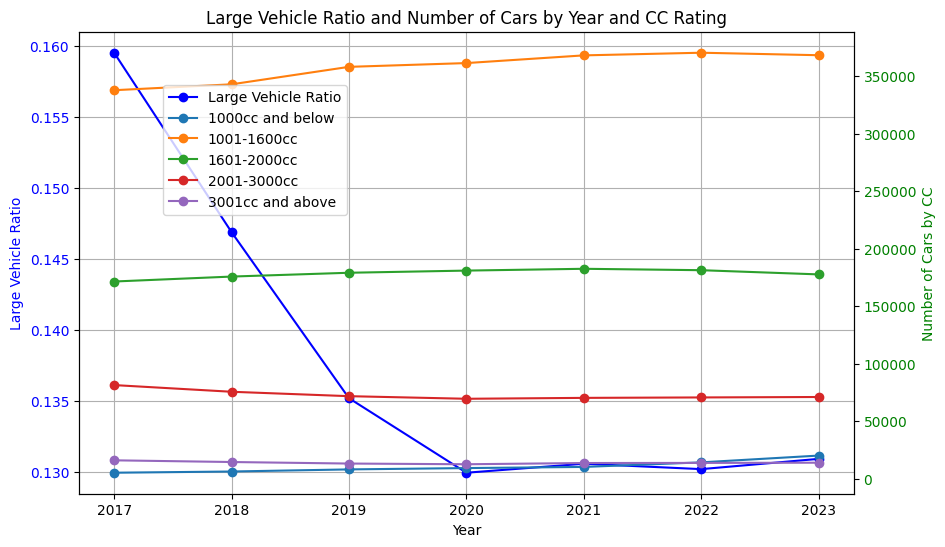

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(yearly_total_vehicles_and_large_vehicle["year"], yearly_total_vehicles_and_large_vehicle["large_vehicle_ratio"], marker='o', linestyle='-', color='b', label='Large Vehicle Ratio')
ax1.set_xlabel('Year')
ax1.set_ylabel('Large Vehicle Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

for cc in vehicle_count_by_year_and_cc.columns:
    ax2.plot(vehicle_count_by_year_and_cc.index, vehicle_count_by_year_and_cc[cc], marker='o', label=cc)

ax2.set_ylabel('Number of Cars by CC', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.title('Large Vehicle Ratio and Number of Cars by Year and CC Rating')
ax1.grid(True)

plt.show()

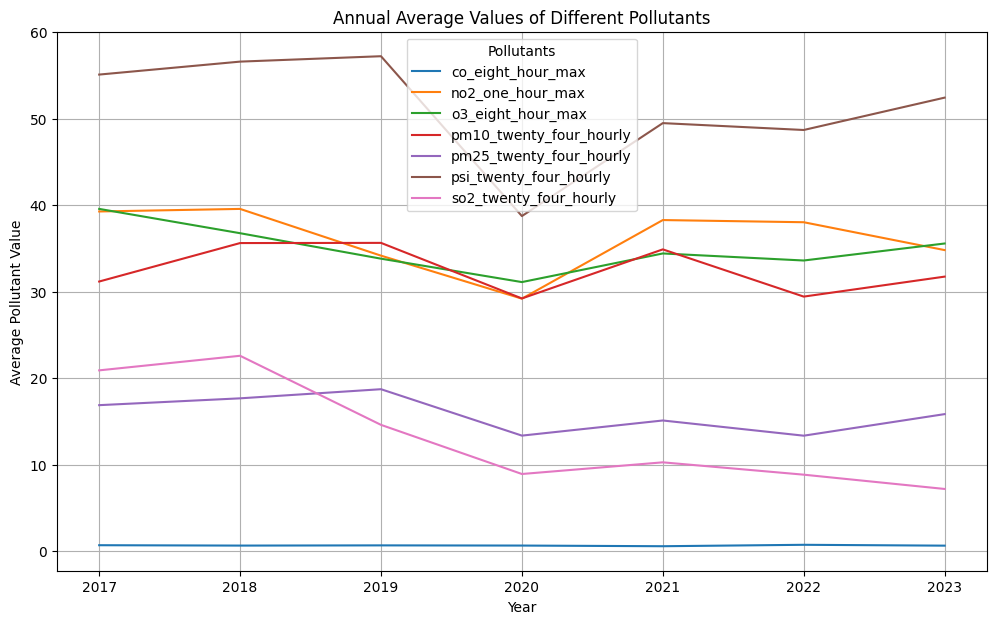

In [54]:
# Extract the pollutant to be analyzed
pollutants = df_yearly_national_pollutant['pollutant'].unique()

plt.figure(figsize=(12, 7))

for pollutant in pollutants:
    # Filter out the current pollutant data
    df_pollutant = df_yearly_national_pollutant[df_yearly_national_pollutant['pollutant'] == pollutant]    
    plt.plot(df_pollutant['year'], df_pollutant['value'], label=pollutant)

plt.title('Annual Average Values of Different Pollutants')
plt.xlabel('Year')
plt.ylabel('Average Pollutant Value')
plt.legend(title='Pollutants')
plt.grid(True)
plt.show()

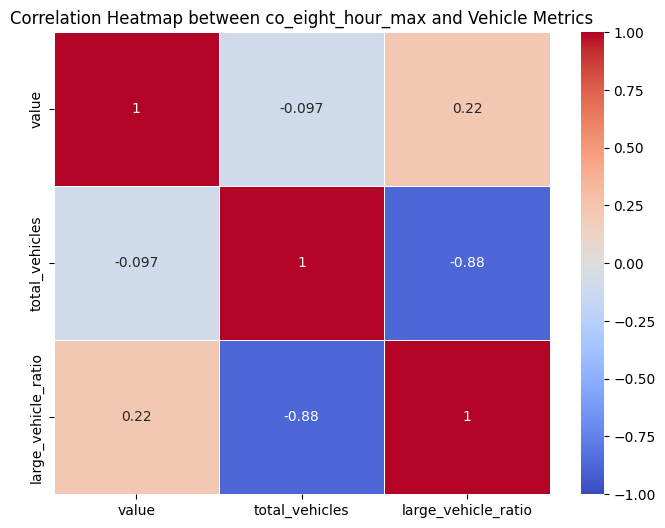

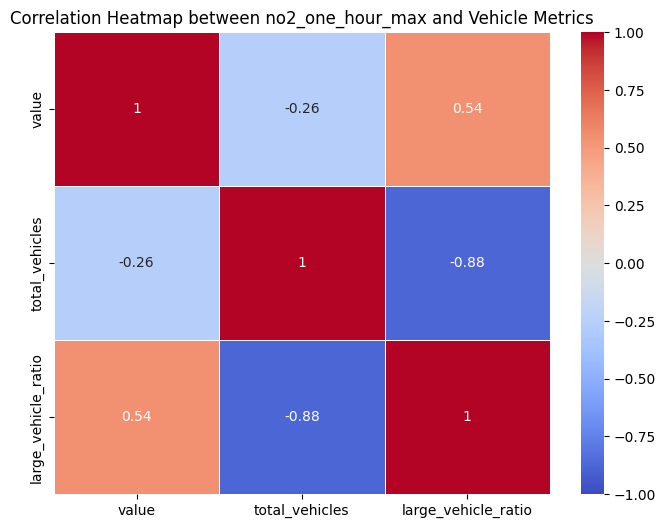

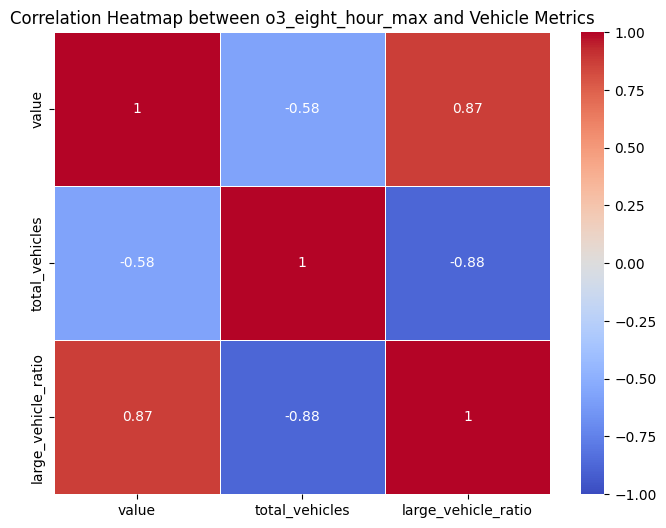

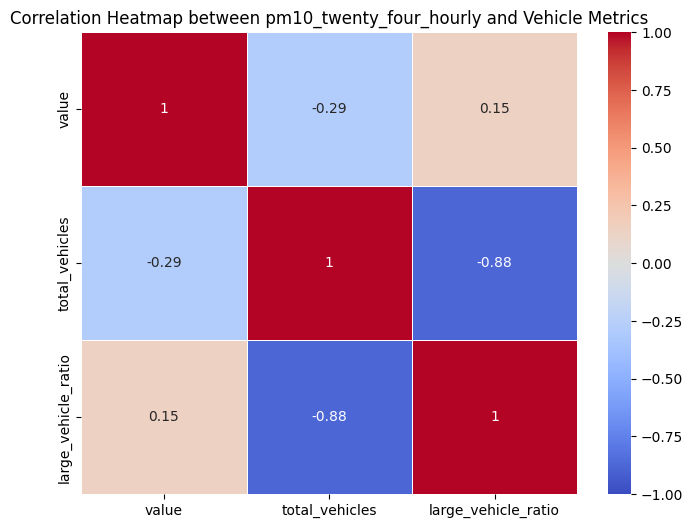

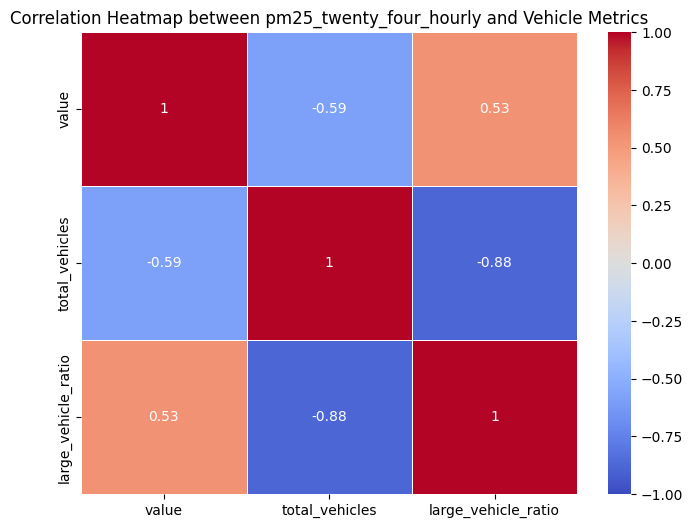

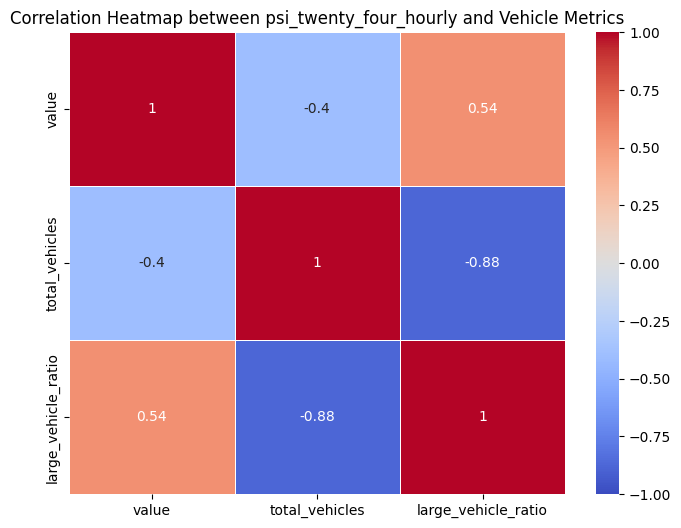

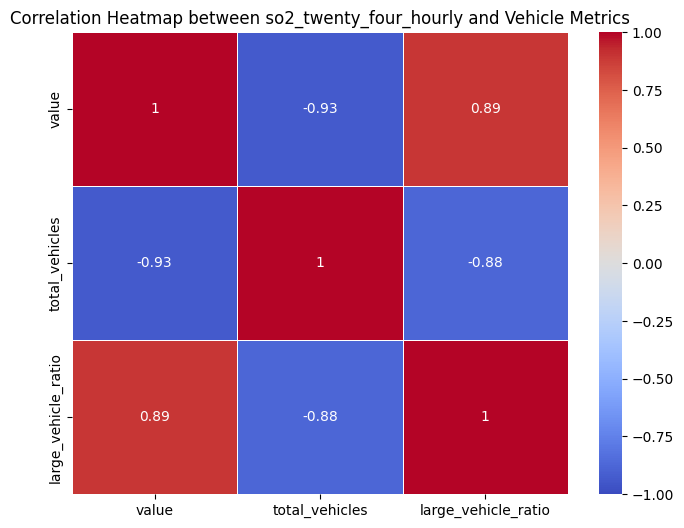

In [55]:
for pollutant in pollutants:
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]

    correlation_matrix = pollutant_data[['value', 'total_vehicles', 'large_vehicle_ratio']].corr()
    
    # Draw heat map to analysis the correlation among pollutant value, total vehicles and large vehicle ratio.
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
    plt.title(f"Correlation Heatmap between {pollutant} and Vehicle Metrics")
    plt.show()

## Part4. Data Modelling and Analysis

## Regression Analysis

### Total Vehicles and Pollutant

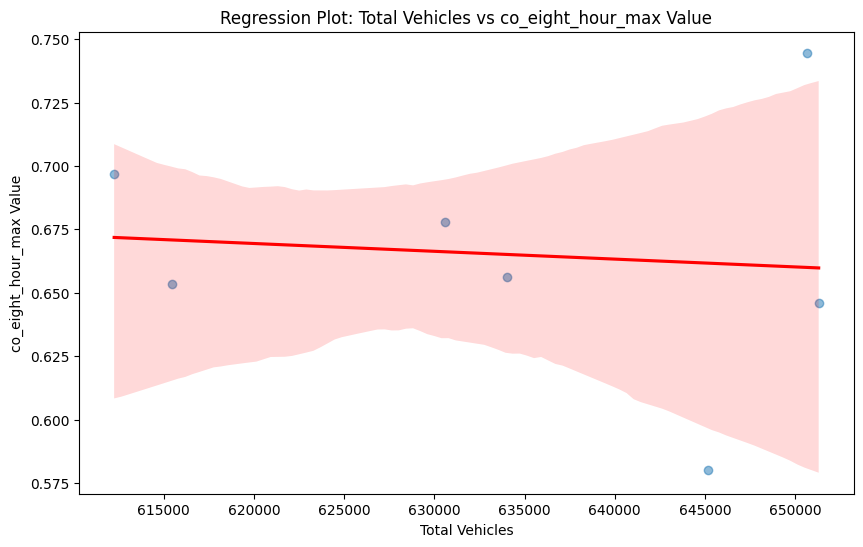

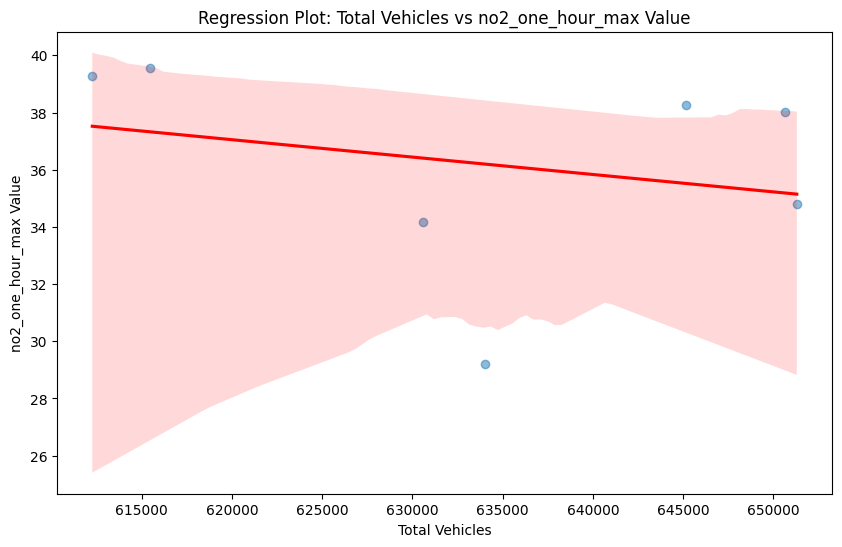

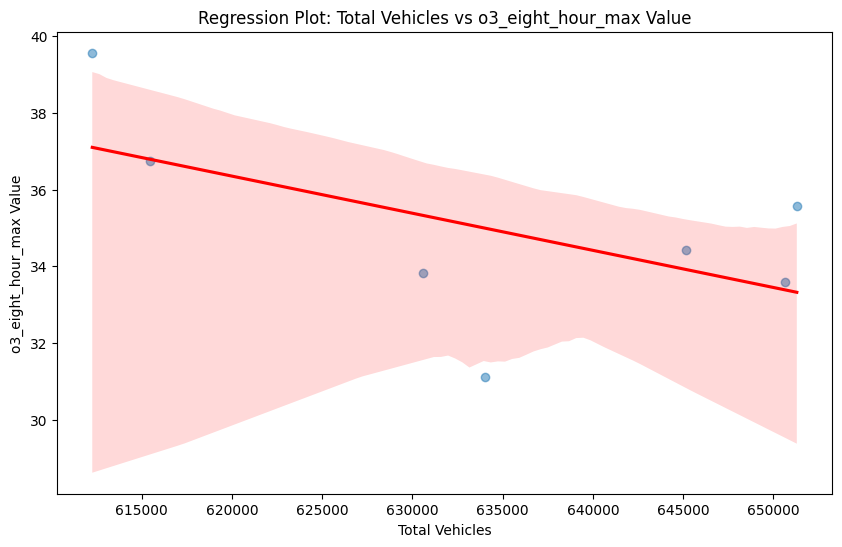

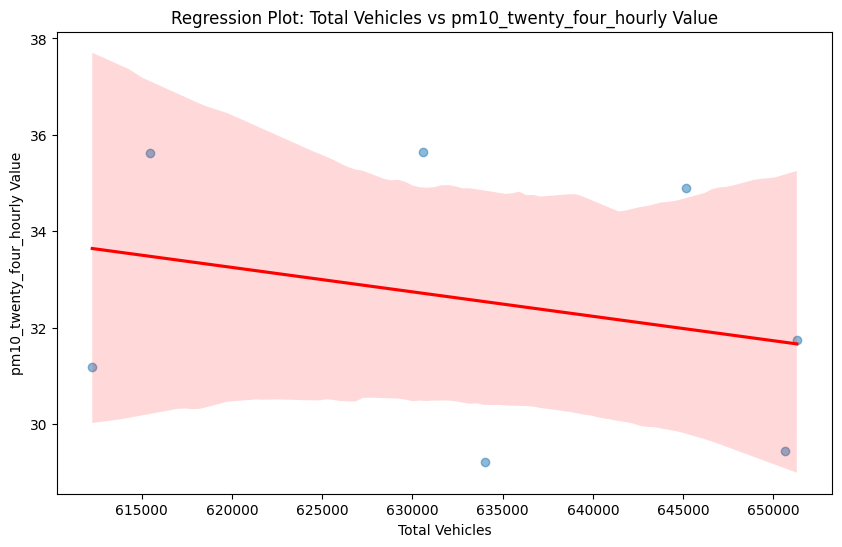

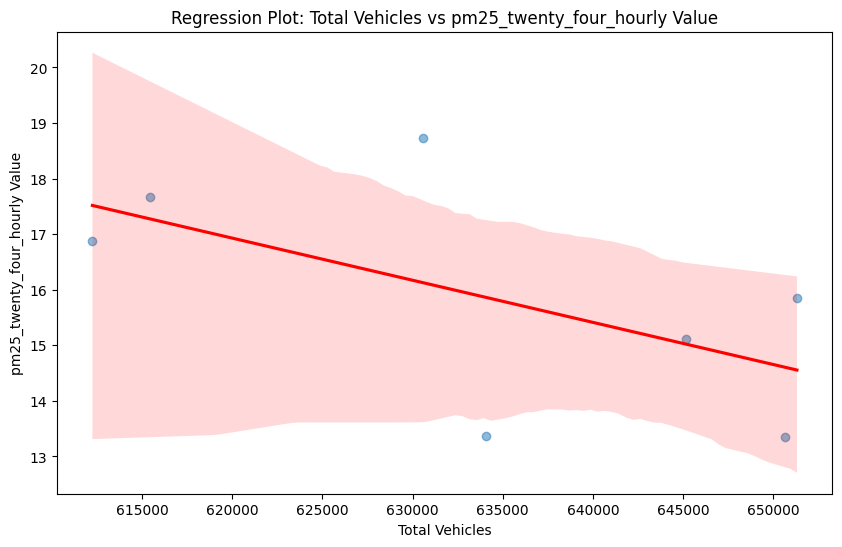

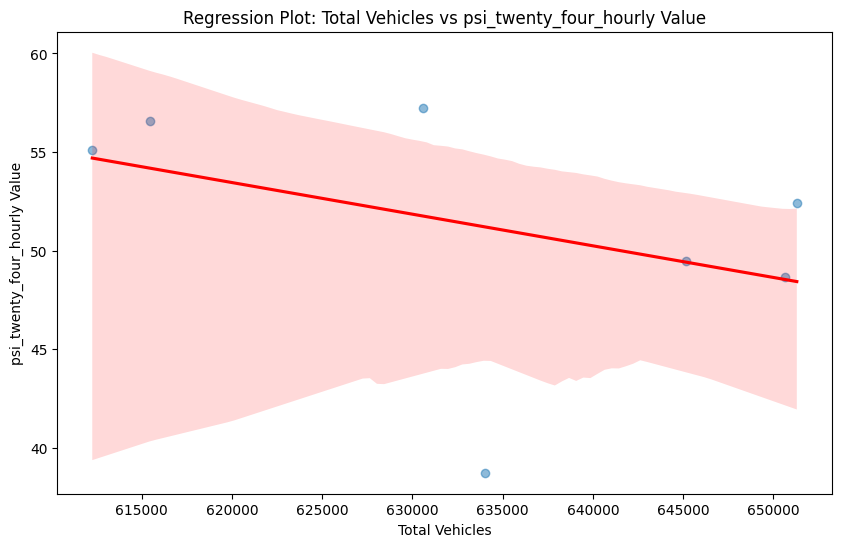

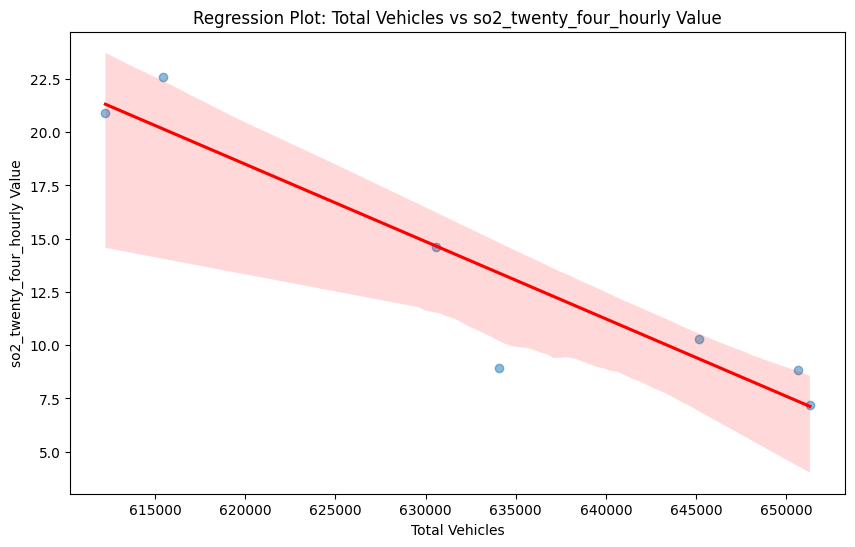

In [56]:

for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    
    # Filter data for current pollutants
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]
    
    # Plot the regression fit of total_vehicles against value
    sns.regplot(x='total_vehicles', y='value', data=pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Total Vehicles vs {pollutant} Value')
    plt.xlabel('Total Vehicles')
    plt.ylabel(f'{pollutant} Value')
    plt.show()
# Calculate the correlation coefficient for each pollutant separately.

## Analysis

### Total Vehicles VS CO

The figure shows the relationship between CO concentration and the total number of vehicles, with a weak downward trend in the regression line. This indicates that as the number of vehicles increases, there is a slight downward trend in CO concentration, but the impact is very small, and the confidence interval is wide, indicating that the data has large uncertainty.

### Total Vehicles VS NO2

There seems to be no obvious relationship between the concentration of NO2 and the total number of vehicles, and the regression line is basically flat. Because it can be seen from the analysis that the concentration of NO2 does not change much with different numbers of vehicles, this may indicate that other factors may have a more significant impact on the concentration of NO2 than the total number of vehicles.

### Total Vehicles VS O3

The O3 concentration, on the contrary, decreased slightly with the increase in the total number of vehicles. I think this trend may be related to the process of NOx emitted by vehicles reacting with sunlight to form O3, indicating that in areas with high vehicle density, local consumption of O3 may occur due to the high level of NOx.

### Total Vehicles VS PM10

The regression plot shows a slight decrease in PM10 concentration with an increase in the number of vehicles. Although the regression line shows a decreasing trend, its confidence interval is large, which indicates high uncertainty in the results and the need for further data to verify this trend.

### Total Vehicles VS PM2.5

The concentration of PM2.5 also decreases with the increase in the number of vehicles. The chart shows that vehicle emissions have a direct impact on PM2.5 concentrations, but I think that since PM2.5 can also be generated by other sources, the accuracy of this relationship still needs to be further studied.

### Total Vehicles VS PSI

The PSI value decreased slightly with the increase in the number of vehicles. The PSI value comprehensively considers multiple pollutants, so this trend reflects the fact that the increase in the number of vehicles has reduced the contribution of some major pollutants.

### Total Vehicles VS SO2

The concentration of SO2 decreased significantly with the number of vehicles. The concentration of SO2 is usually associated with heavy industry and the use of high-sulphur fuels, which means that the impact of vehicles is relatively small or the type of fuel used is changing






### Large Vehicle Ratio and Pollutant

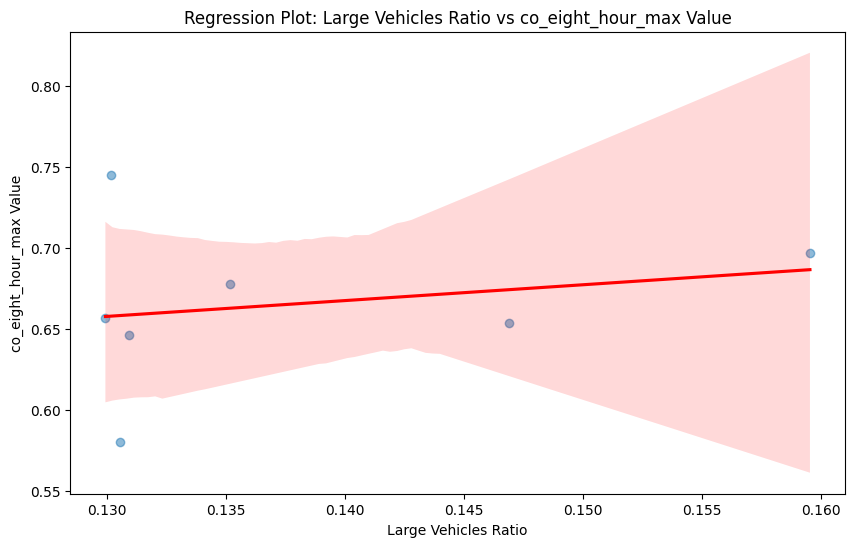

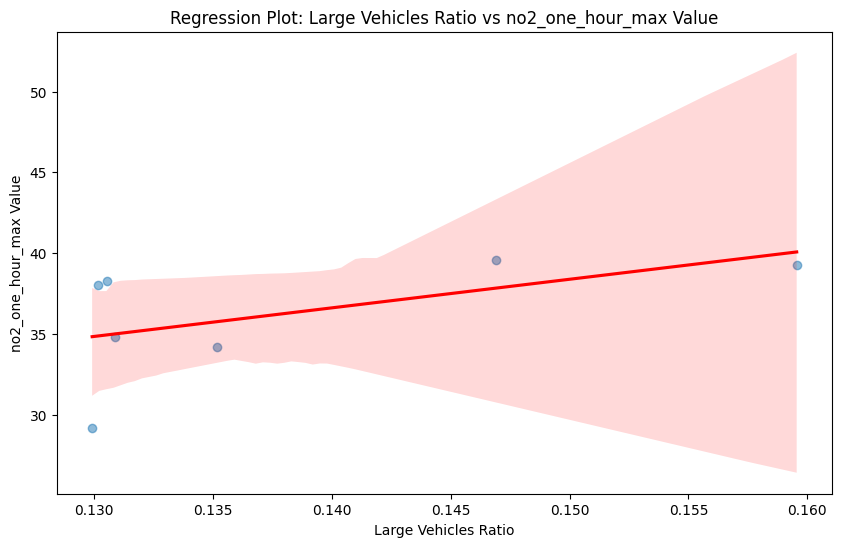

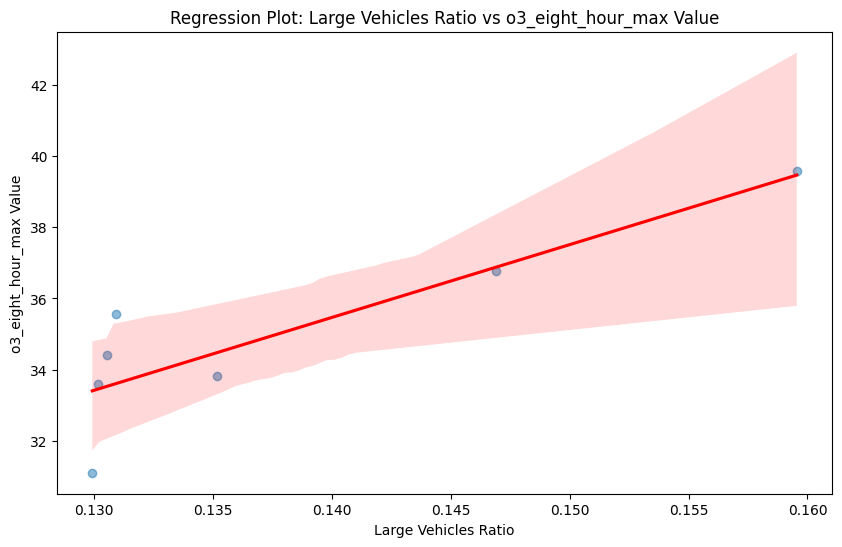

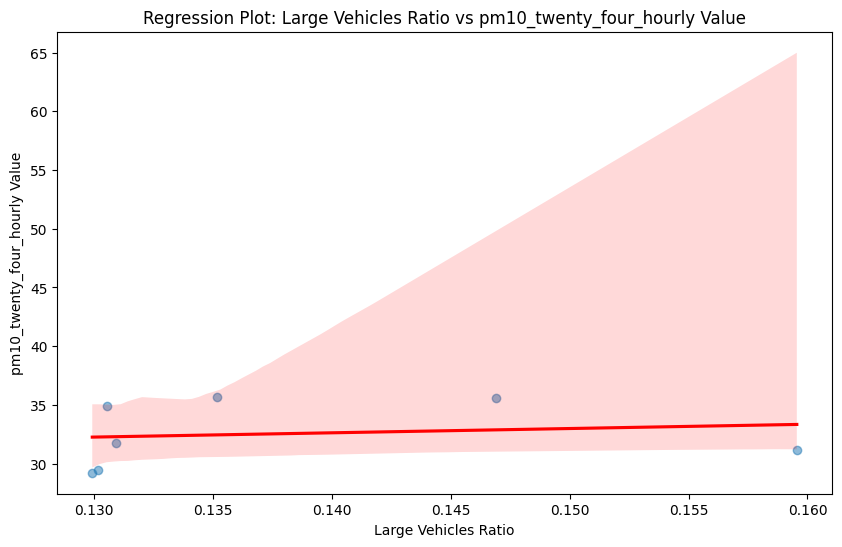

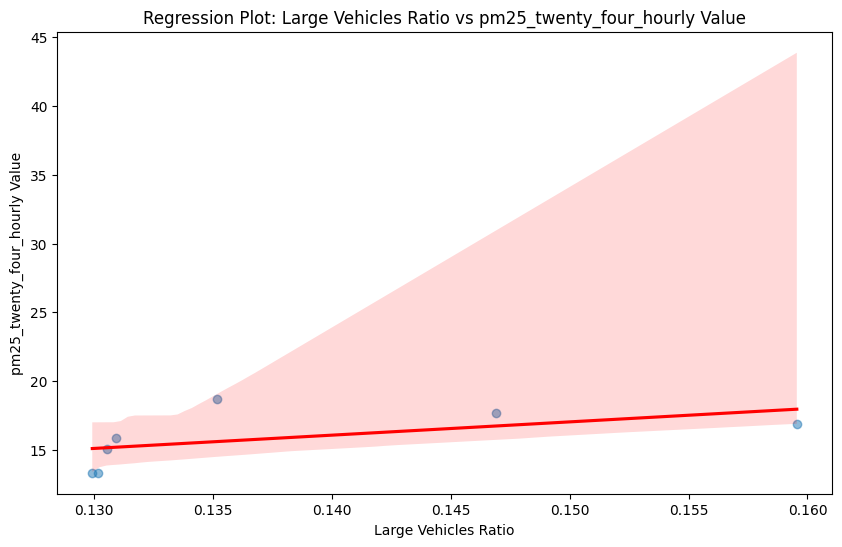

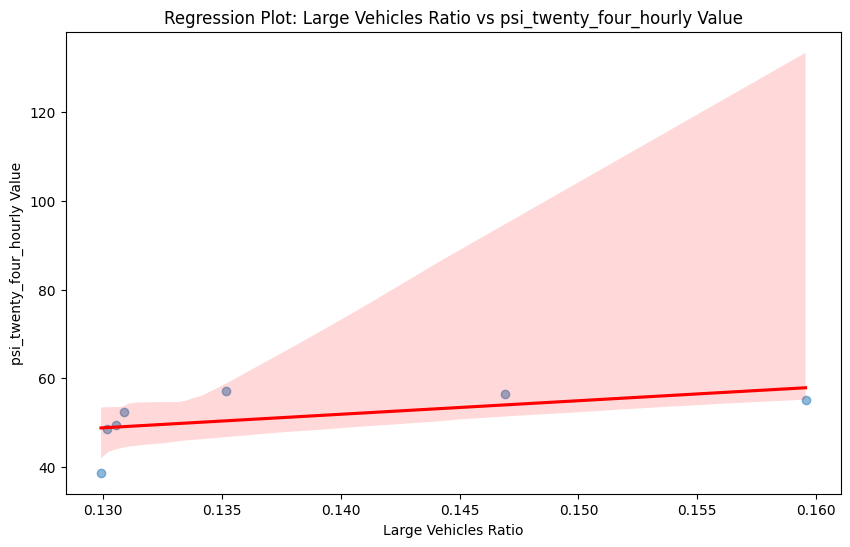

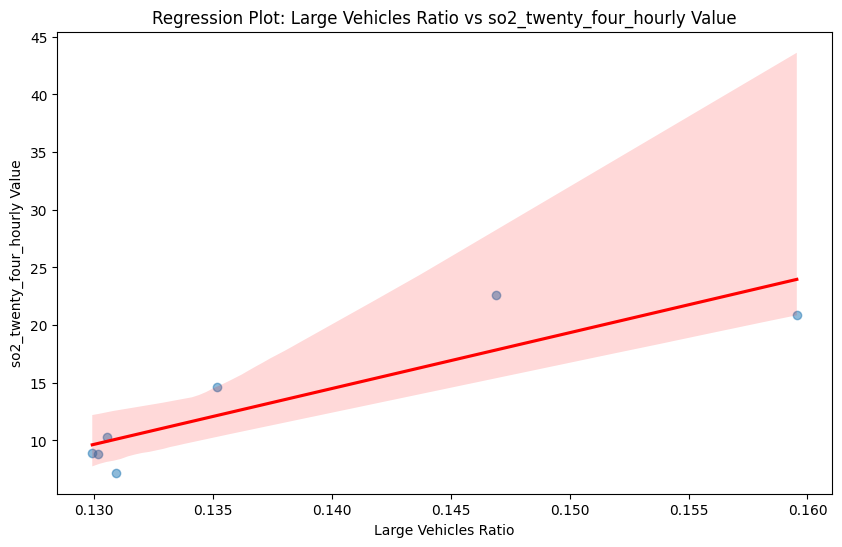

In [57]:

for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    
    # Filter data for current pollutants
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]
    
    # Plot the regression fit of total_vehicles against value
    sns.regplot(x='large_vehicle_ratio', y='value', data=pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Large Vehicles Ratio vs {pollutant} Value')
    plt.xlabel('Large Vehicles Ratio')
    plt.ylabel(f'{pollutant} Value')
    plt.show()

## Large Vehicles Ratio vs CO

Although there is a positive correlation between CO concentration and the proportion of large vehicles, the correlation is not strong. I think this is because CO mainly comes from vehicle exhaust, especially when fuel is incompletely combusted, and large vehicles with large displacement have higher CO emissions, but this effect is not very obvious in the data.

## Large Vehicles Ratio vs NO2

The concentration of NO2 is also positively correlated with the proportion of large vehicles, which indicates that as the proportion of large vehicles increases, the concentration of NO2 also tends to increase. NO2 is usually directly related to vehicle exhaust emissions, especially from large diesel vehicles, which explains this positive correlation.

## Large Vehicles Ratio vs O3

The concentration of O3 is positively correlated with the proportion of large vehicles, and this trend is more pronounced than for other pollutants. Although O3 is not directly emitted, it is usually produced by the reaction of NOx and VOCs (volatile organic compounds) in sunlight. I believe that an increase in vehicles may lead to an increase in these precursors, which indirectly increases O3.


## Large Vehicles Ratio vs PM10 and PM2.5

Both particulate matter concentrations are positively correlated with the proportion of large vehicles, especially PM10. These particulates are directly related to vehicle emissions, especially those from diesel vehicles. Large vehicles tend to emit more particulates.

## Large Vehicles Ratio vs PSI and SO2

The PSI and SO2 concentrations are positively correlated with the proportion of large vehicles, especially the SO2 concentration. SO2 is mainly derived from the combustion of sulfur in fuel, and the main reason is that the diesel fuel used by large vehicles contains a higher sulfur content.

# Predict the concentration of various pollutants

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


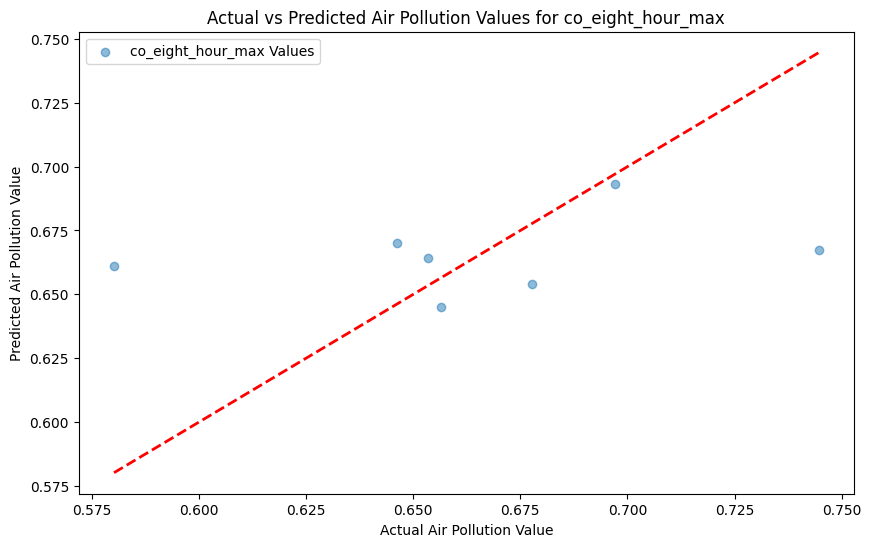

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


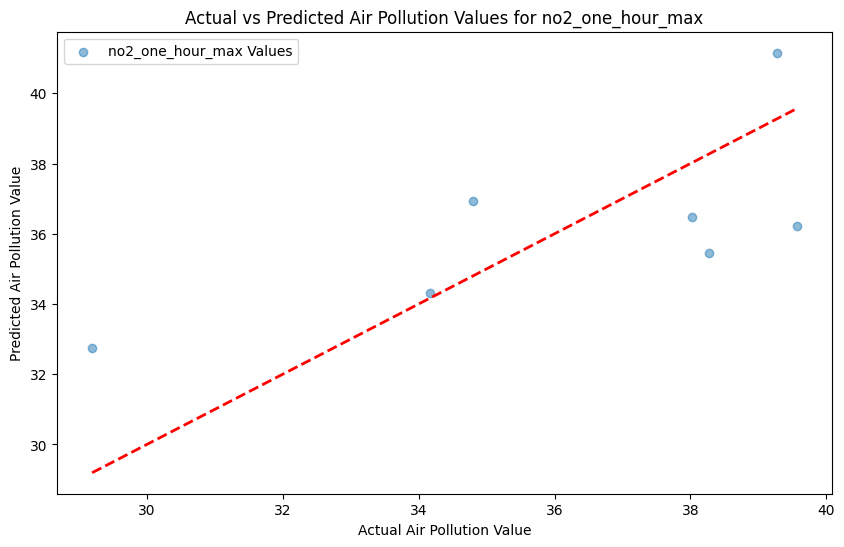

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


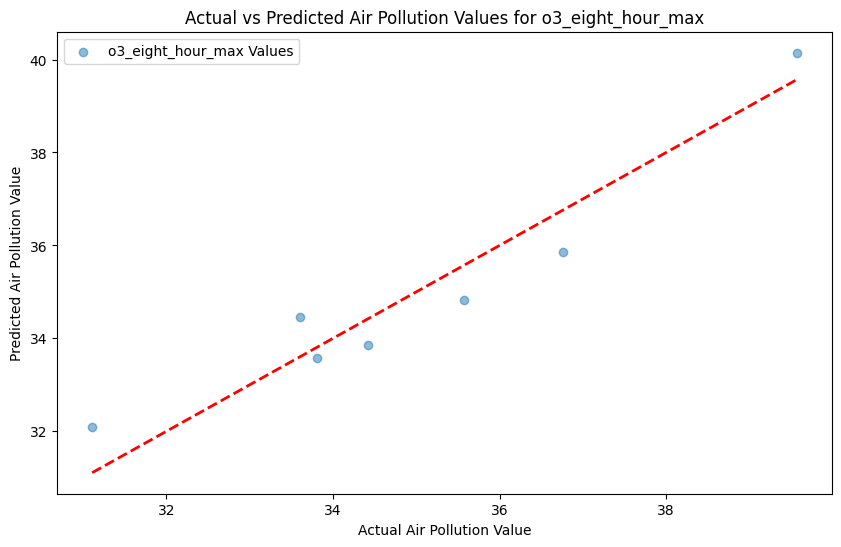

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


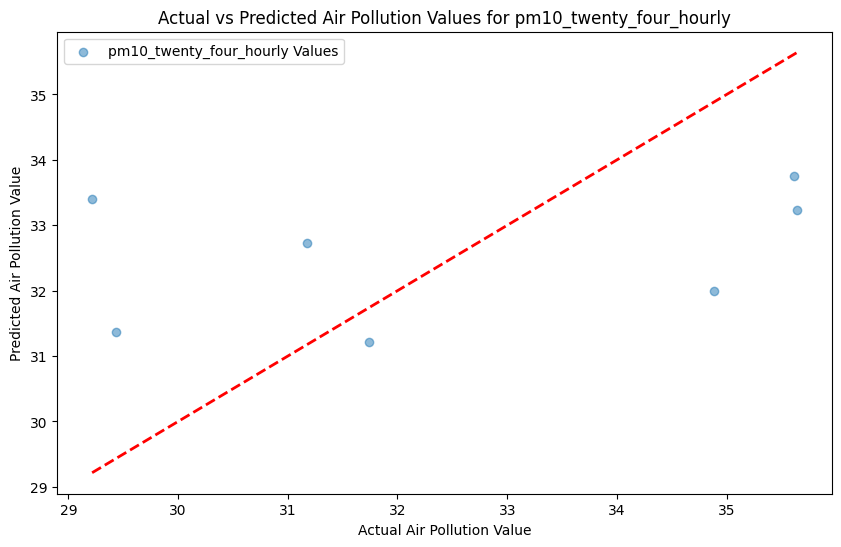

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


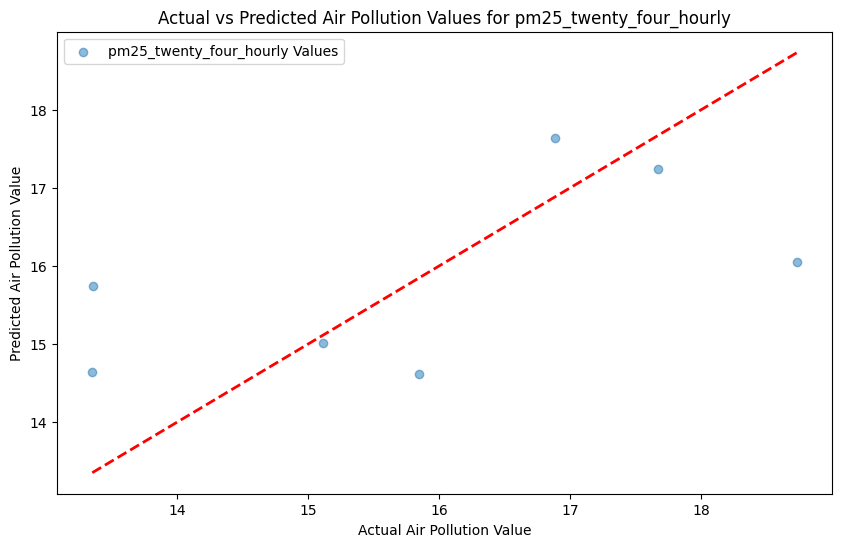

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


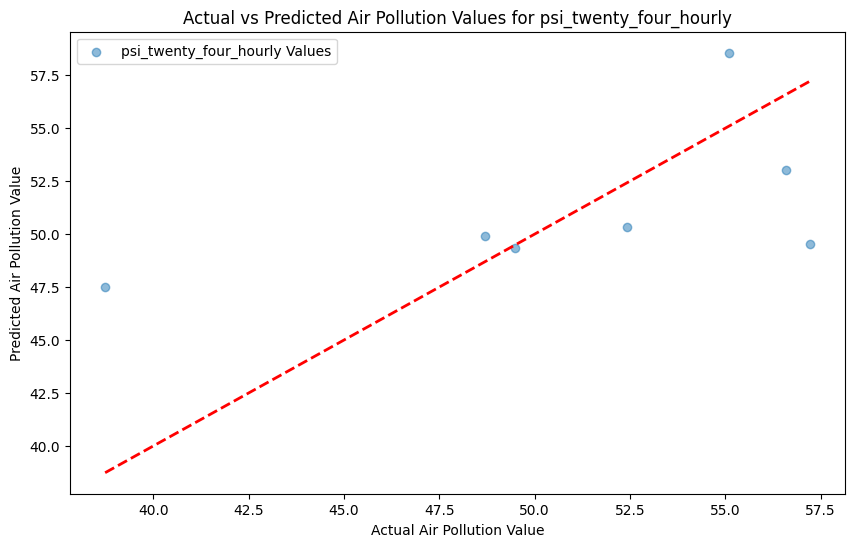

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/471886526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_data['predicted_value'] = model.predict(X)


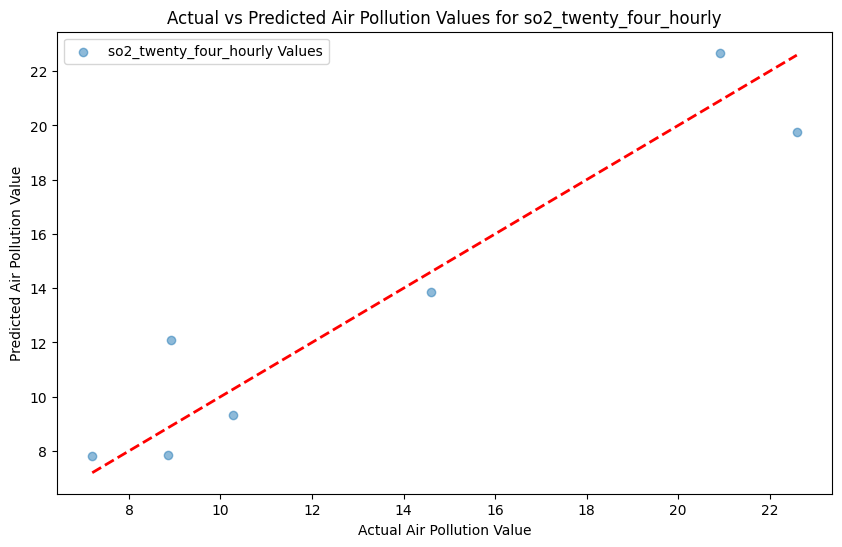

In [58]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming 'pollutants' is a list of pollutant types and 'merged_data' is your DataFrame
for pollutant in pollutants:
    pollutant_data = merged_data[merged_data['pollutant'] == pollutant]
    X = pollutant_data[['total_vehicles', 'large_vehicle_ratio']]
    X = sm.add_constant(X)  # Add a constant term for the intercept
    y = pollutant_data['value']

    model = sm.OLS(y, X).fit()
    pollutant_data['predicted_value'] = model.predict(X)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(pollutant_data['value'], pollutant_data['predicted_value'], alpha=0.5, label=f'{pollutant} Values')
    plt.plot([pollutant_data['value'].min(), pollutant_data['value'].max()], 
             [pollutant_data['value'].min(), pollutant_data['value'].max()], 'r--', lw=2)
    plt.title(f'Actual vs Predicted Air Pollution Values for {pollutant}')
    plt.xlabel('Actual Air Pollution Value')
    plt.ylabel('Predicted Air Pollution Value')
    plt.legend()
    plt.show()

## Analysis

In this module, we used two characteristics – total vehicle count and large vehicle ratio – to build a linear prediction model for various pollutant concentrations. The model estimates the value of the actual pollutant concentration from these input variables.

### CO

The scatter diagram shows a clear linear relationship, and the model's predicted values are very close to the actual values, indicating that the model has a certain predictive ability for CO levels. The trend in this graph is close to the red dotted line, but there is a significant deviation at higher levels.

### NO2

The graph also shows a linear relationship for NO2. However, compared to CO, the difference between the actual value and the predicted line is greater, which indicates that other variables not included in the model impact NO2 levels or that the accuracy of the model for this pollutant is lower.

### O3

Compared to NO2, this graph shows a denser cluster of points around the regression line, indicating that the model can more accurately predict O3 levels. Furthermore, the trend shows that the model's prediction accuracy remains relatively stable as O3 levels increase.

### PM10

The scatter plot shows an insignificant linear relationship and significant dispersion. This indicates that the model has limited predictive power for PM10 levels and that other important factors may cause PM10 concentrations to increase but are not captured by the model.

### PM2.5

Similar to PM10, the scatter plot for PM2.5 also shows considerable dispersion. There is a significant difference between the model's predicted and actual values, especially in the case of high pollution levels, which indicates the model's limitations in accurately predicting PM2.5 levels.

### PSI

The scatter plot for PSI shows that the model performs well for lower PSI values, but the deviation increases as the PSI value rises. This indicates that although the model is quite effective in predicting normal air quality conditions, it performs poorly in more severe pollution conditions.

### SO2

The regression line for SO2 shows that the model has some predictive power, but as with PM2.5 and PM10, the accuracy of the prediction decreases as the pollution level increases. This may be because the model does not take into account changes in the sources of SO2 or changes in atmospheric conditions that affect SO2 levels.

In [59]:
import pandas as pd

ml_data = merged_data.pivot_table(
    index=['year', 'total_vehicles', 'large_vehicle_ratio'],  
    columns='pollutant',  # Convert pollutant types to columns
    values='value'  
).reset_index()


ml_data.columns.name = None  

print(ml_data)

   year  total_vehicles  large_vehicle_ratio  co_eight_hour_max  \
0  2017          612256             0.159553           0.697020   
1  2018          615452             0.146894           0.653361   
2  2019          630596             0.135177           0.677824   
3  2020          634042             0.129920           0.656387   
4  2021          645150             0.130554           0.580130   
5  2022          650667             0.130174           0.744620   
6  2023          651302             0.130898           0.646103   

   no2_one_hour_max  o3_eight_hour_max  pm10_twenty_four_hourly  \
0         39.269421          39.566390                31.172609   
1         39.564703          36.757087                35.617956   
2         34.162070          33.812460                35.638672   
3         29.192954          31.108189                29.216425   
4         38.276330          34.416556                34.887320   
5         38.025381          33.601690                29.4301

# PCA

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(ml_data[['total_vehicles']+['large_vehicle_ratio'] + ['co_eight_hour_max']+['no2_one_hour_max'] +['o3_eight_hour_max']+  ['pm10_twenty_four_hourly']+['pm25_twenty_four_hourly'] + ['psi_twenty_four_hourly']+  ['so2_twenty_four_hourly']]
)

pca = PCA(n_components=2)
print("Variance explained by each component:", pca.explained_variance_ratio_)

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

## Analysis

First, the features in the data set are standardised using the StandardScaler. The data dimensions are then reduced to two principal components. This means that the original data set is transformed into a new coordinate system, where the axes (principal components) are oriented in the direction of the largest variances. The output [0.57621765, 0.19394862] indicates the proportion of the variance in the data set that is along each principal component. In other words, the first component accounts for approximately 57.62% of the variance, while the second component accounts for approximately 19.39% of the variance.

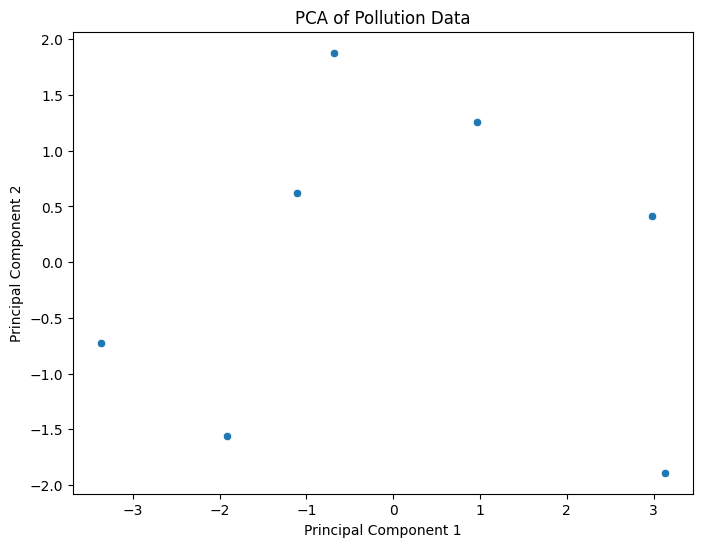

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()

# conduct PCA
pca = PCA(n_components=2)  # choose two component
principal_components = pca.fit_transform(features_scaled)
ml_data['PC1'] = principal_components[:, 0]
ml_data['PC2'] = principal_components[:, 1]

# Visilization
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=ml_data)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Pollution Data')
plt.show()

# Check all variance explained by each component

Variance explained by each component: [5.78416901e-01 2.11809858e-01 9.23636924e-02 8.03740240e-02
 3.58974194e-02 1.13810475e-03 5.67627540e-34]
Cumulative variance explained: [0.5784169  0.79022676 0.88259045 0.96296448 0.9988619  1.
 1.        ]


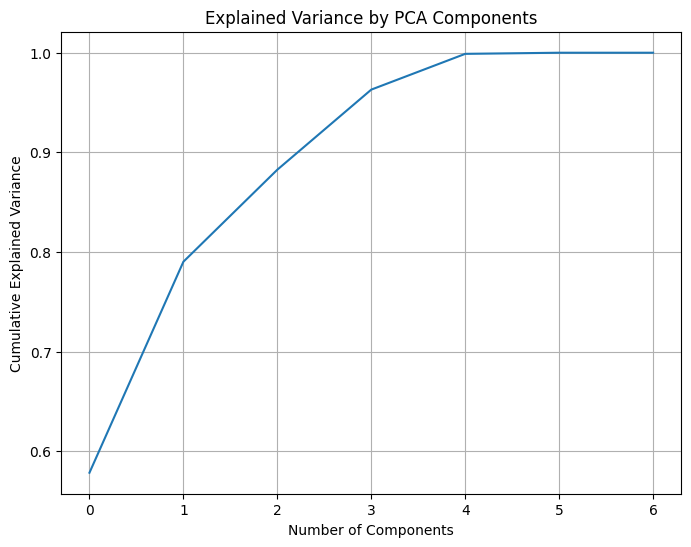

In [63]:
features_scaled = scaler.fit_transform(ml_data[['large_vehicle_ratio'] + ['co_eight_hour_max']+['no2_one_hour_max'] +['o3_eight_hour_max']+  ['pm10_twenty_four_hourly']+['pm25_twenty_four_hourly'] + ['psi_twenty_four_hourly']+  ['so2_twenty_four_hourly']])

pca = PCA()
pca.fit(features_scaled)

print("Variance explained by each component:", pca.explained_variance_ratio_)

cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("Cumulative variance explained:", cumulative_variance)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

## Linear Legression Models with time as a trend

In [64]:

pollutants = ['co_eight_hour_max', 'no2_one_hour_max', 'o3_eight_hour_max', 
              'pm10_twenty_four_hourly', 'pm25_twenty_four_hourly', 'psi_twenty_four_hourly', 
              'so2_twenty_four_hourly']

ml_data['trend'] = range(len(ml_data))

for pollutant in pollutants:
    X = ml_data[['large_vehicle_ratio', 'trend']] 
    X = sm.add_constant(X)  
    y = ml_data[pollutant] 

    model = sm.OLS(y, X).fit() 
    print(f"Regression results for {pollutant}:")
    print(model.summary())  

Regression results for co_eight_hour_max:
                            OLS Regression Results                            
Dep. Variable:      co_eight_hour_max   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                 -0.394
Method:                 Least Squares   F-statistic:                    0.1520
Date:                Fri, 11 Oct 2024   Prob (F-statistic):              0.864
Time:                        19:49:10   Log-Likelihood:                 11.764
No. Observations:                   7   AIC:                            -17.53
Df Residuals:                       4   BIC:                            -17.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

/Users/bytedance/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/bytedance/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/bytedance/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/bytedance/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.

## Analysis

The results show that the model can better explain the variability of ozone and SO2 levels, but the R-squared values for different pollutants vary greatly, which indicates that the impact of vehicle traffic (especially large vehicles) and time trends on different types of air pollution is not consistent. And the lack of statistical significance in many cases may be due to the relatively small sample size, which limits the effectiveness of statistical tests and increases the uncertainty of the estimates.

## Part5. Comparative Analysis Between Singapore and Hong Kong

## Data Collection & Preprocessing

### Hypothesis

Air pollution levels in Hong Kong are influenced by both the total number of vehicles and the proportion of high-emission vehicles (above 2000cc) within the vehicle population. Larger vehicles, with higher engine capacities, are expected to contribute more significantly to air pollution, especially in dense urban areas.

### Datasets Selection

For this analysis, two key datasets were selected, which together provide a comprehensive view of air quality and vehicle trends in Hong Kong from 2017 to 2024:

	•	Hong Kong Air Quality Data (2017–2023): This dataset contains daily air pollutant measurements for various regions in Hong Kong. The pollutants tracked include nitrogen dioxide (NO₂), carbon monoxide (CO), fine suspended particulates (PM2.5), respirable suspended particulates (PM10), and sulfur dioxide (SO₂). These pollutants are directly linked to vehicular emissions and are therefore critical to the hypothesis.
	•	Hong Kong Vehicle Statistics (2020–2024): This dataset contains annual data on the number of vehicles registered in Hong Kong, categorized by engine capacity (cc rating). The dataset includes a breakdown of vehicles from 1000cc and below to those exceeding 3000cc. This data allows for an examination of trends in vehicle numbers and the impact of larger vehicles on air pollution.

These datasets were chosen for their relevance in understanding how vehicle emissions affect air quality. The overlap in the time period (2017–2023) allows for the two datasets to be compared and analyzed together.

### Data Cleaning and Preparation

Several data cleaning steps were undertaken to ensure the datasets were suitable for analysis:

	1.	Air Quality Data:
	•	The air quality dataset was first checked for missing values and duplicates using .isnull() and .duplicated() methods. Handling these issues ensured the dataset was complete and accurate.
	•	The column names were stripped of any leading or trailing spaces and converted to lowercase for consistency.
	•	The date column was converted to datetime format to allow for time-based analysis, and the value column (representing pollutant concentration levels) was converted to numeric, with invalid entries handled by setting them to NaN.
	•	Outliers in the pollutant values were identified using the Interquartile Range (IQR) method, which is a robust approach for detecting extreme values. This step ensured that abnormal values did not distort the results.
	2.	Vehicle Data:
	•	The vehicle dataset was also cleaned by checking for missing values and duplicates. Duplicate records were removed to avoid skewing the analysis.
	•	Outliers in the number column (representing the number of vehicles) were identified using the IQR method. This helped in detecting any unusual spikes in vehicle numbers, though none were found to be problematic.

### Feature Engineering

To better align the datasets with the hypothesis, several new features were created:

	•	Engine Capacity Classification: A binary column (above_2000cc) was created to mark whether a vehicle’s engine capacity exceeded 2000cc. This feature is important for understanding the impact of larger, high-emission vehicles on air pollution.
	•	Yearly Aggregation of Pollutants: The pollutant data was aggregated by year, region, and pollutant type to calculate annual average values. This aggregation allows for the analysis of long-term trends in air quality, aligning it with the annual vehicle data.
	•	Vehicle Aggregation by Year: The vehicle data was grouped by year and engine capacity, enabling the calculation of total vehicles and the number of large vehicles (above 2000cc) for each year. This step is crucial for comparing trends in vehicle populations with air quality levels.

### Merging the Datasets

After preprocessing, the air quality and vehicle datasets were merged on the year column. This allowed for direct comparisons between the total number of vehicles, the proportion of large vehicles, and the pollutant levels for each year. By merging the datasets, we can explore the relationships between vehicle trends and air pollution, setting the foundation for further analysis.

This preprocessing and feature engineering process ensures that the data is clean, aligned, and ready for further analysis, such as statistical modeling or visualization, to investigate the link between vehicular emissions and air quality.

Add the data recourse:

Car:

URl:https://data.gov.hk/sc-data/dataset/hk-td-wcms_11-first-reg-vehicle

Air quilty:

URL:https://cd.epic.epd.gov.hk/EPICDI/air/station/?lang=en



In [66]:
import pandas as pd
import os

# Folder path containing data files for multiple years
folder_path = 'HongKong/hongkong car data/'

# List all files in the folder and filter out those from 2020 and onwards
years = [2020, 2021, 2022, 2023, 2024]
files = {year: [f for f in os.listdir(folder_path) if str(year) in f] for year in years}

# Define a function to categorize engine size ranges
def categorize_engine_size(cc):
    if cc <= 1000:
        return '1000cc and below'
    elif 1001 <= cc <= 1600:
        return '1001-1600cc'
    elif 1601 <= cc <= 2000:
        return '1601-2000cc'
    elif 2001 <= cc <= 3000:
        return '2001-3000cc'
    else:
        return '3001cc and above'

# Define output file
output_file = 'HongKong/output_vehicle_statistics.csv'

# Clear the contents of the output file and write the header
with open(output_file, 'w') as f:
    f.write('year,cc_rating,number\n')

# Iterate through each year
for year, file_list in files.items():
    all_data = pd.DataFrame()  # To store all monthly data for the year

    # Iterate through each month's file for the year
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        
        # Read the file data
        df = pd.read_csv(file_path)
        
        # Convert the "Cylinder Capacity Of Engine (c.c.)" column to numeric, setting errors to NaN
        df['Cylinder Capacity Of Engine (c.c.)'] = pd.to_numeric(df['Cylinder Capacity Of Engine (c.c.)'], errors='coerce')
        
        # Drop rows where engine capacity is missing (i.e., cannot be converted to numeric)
        df = df.dropna(subset=['Cylinder Capacity Of Engine (c.c.)'])
        
        # Add a new column to categorize engine size ranges
        df['cc_rating'] = df['Cylinder Capacity Of Engine (c.c.)'].apply(categorize_engine_size)
        
        # Add a year column
        df['year'] = year
        
        # Concatenate the monthly data into the year's data
        all_data = pd.concat([all_data, df], ignore_index=True)

    # Aggregate the annual engine size statistics
    annual_counts = all_data.groupby(['year', 'cc_rating']).size().reset_index(name='number')

    # Append the annual aggregated data to the CSV file without writing the header
    annual_counts.to_csv(output_file, mode='a', header=False, index=False)

print(f'Statistics for 2020-2024 saved to {output_file}')




Statistics for 2020-2024 saved to HongKong/output_vehicle_statistics.csv


In [67]:
import pandas as pd
import os

def process_file(file_path, output_file):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert data to long format
    df_melted = df.melt(id_vars=['DATE', 'POLLUTANT'], var_name='region', value_name='value')

    # Filter out 'N.A.' data (Uncomment if needed)
    # df_melted = df_melted[df_melted['value'] != 'N.A.']

    # Convert the 'DATE' column to datetime format to ensure correct sorting
    df_melted['DATE'] = pd.to_datetime(df_melted['DATE'], format='%d-%m-%Y')

    # Sort by DATE and region
    df_sorted = df_melted.sort_values(by=['DATE', 'region'])

    # Check if the output file exists
    if os.path.exists(output_file):
        # If the file exists, clear its content by opening it in write mode and writing the header
        with open(output_file, 'w') as f:
            f.write('DATE,POLLUTANT,region,value\n')
    else:
        # If the file does not exist, create it and write the header
        with open(output_file, 'w') as f:
            f.write('DATE,POLLUTANT,region,value\n')

    # Write the processed and sorted data to the output file in append mode without writing the header again
    df_sorted.to_csv(output_file, mode='a', header=False, index=False)

if __name__ == "__main__":
    # Input file path
    input_file = 'HongKong/air_daily.csv'  # Replace with your input file path
    # Output file path
    output_file = 'HongKong/fix_air_daily.csv'  # Replace with your desired output file path

    # Process a single file
    process_file(input_file, output_file)

    print(f'File processed and sorted. Results saved to {output_file}.')





File processed and sorted. Results saved to HongKong/fix_air_daily.csv.


In [68]:
# import hk air quality from 2017 to 2023.
hk_air = pd.read_csv('HongKong/fix_air_daily.csv')
# import hk vehicle data from 2020 to 2024.
hk_vehicle = pd.read_csv('HongKong/output_vehicle_statistics.csv')  

In [69]:
# Check whether there are null values in hk_air.
hk_air.isnull().sum()

DATE         0
POLLUTANT    0
region       0
value        0
dtype: int64

In [70]:
# Strip any leading/trailing spaces and convert all column names to lowercase
hk_air.columns = hk_air.columns.str.strip().str.lower()

# Check the updated column names to confirm
print(hk_air.columns)

Index(['date', 'pollutant', 'region', 'value'], dtype='object')


In [71]:
# Determine whether there are null values in hk_vehicle.
hk_vehicle.isnull().sum()

year         0
cc_rating    0
number       0
dtype: int64

In [72]:
# Check whether there are duplicated values in hk_air.
print(f"There are {hk_air.duplicated().sum()} duplicates in hk_air DataFrame")
# Check whether there are duplicated values in hk_vehicle.
print(f"There are {hk_vehicle.duplicated().sum()} duplicates in hk_vehicle DataFrame")
if hk_vehicle.duplicated().sum() > 0:
    duplicates_hk_vehicle = hk_vehicle[hk_vehicle.duplicated()]
    hk_vehicle = hk_vehicle.drop(duplicates_hk_vehicle.index)
# Check whether there are duplicated values in hk_vehicle.
print(f"There are {hk_vehicle.duplicated().sum()} duplicates in hk_vehicle DataFrame after processed")

# Convert  hk_air 'date' column type to datetime
hk_air['date'] = pd.to_datetime(hk_air['date'])
# Convert hk_air 'value' column to numeric, forcing errors to NaN
hk_air['value'] = pd.to_numeric(hk_air['value'], errors='coerce')
# Drop rows with NaN values in hk_air 'value' column if necessary
hk_air = hk_air.dropna(subset=['value'])
# Ensure 'value' is treated as a numeric column
print(hk_air.dtypes)

There are 0 duplicates in hk_air DataFrame
There are 0 duplicates in hk_vehicle DataFrame
There are 0 duplicates in hk_vehicle DataFrame after processed
date         datetime64[ns]
pollutant            object
region               object
value               float64
dtype: object


In [73]:
# Create a dictionary to store outliers for air quality
outliers_dict = {}

# Iterate over each unique pollutant
for pollutant in hk_air['pollutant'].unique():
    hk_pollutant = hk_air[hk_air['pollutant'] == pollutant]
    
    # Calculate IQR
    Q1 = hk_pollutant['value'].quantile(0.25)
    Q3 = hk_pollutant['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the outliers
    outliers = hk_pollutant[
        (hk_pollutant['value'] < lower_bound) | 
        (hk_pollutant['value'] > upper_bound)
    ]

    # Store the result
    if outliers.empty:
        print(f"No outliers found for {pollutant}")
    else:
        print(outliers.head())
        outliers_dict[pollutant] = outliers

           date        pollutant    region  value
889  2017-01-08  Carbon Monoxide   CENTRAL  139.0
924  2017-01-08  Carbon Monoxide  MONG KOK  126.0
1015 2017-01-09  Carbon Monoxide   CENTRAL  139.0
1050 2017-01-09  Carbon Monoxide  MONG KOK  138.0
1092 2017-01-09  Carbon Monoxide   TAP MUN  130.0
          date                     pollutant        region  value
253 2017-01-03  Fine Suspended Particulates   CAUSEWAY BAY   44.0
358 2017-01-03  Fine Suspended Particulates       TUEN MUN   49.0
365 2017-01-03  Fine Suspended Particulates     TUNG CHUNG   44.0
610 2017-01-05  Fine Suspended Particulates       TUEN MUN   45.0
631 2017-01-06  Fine Suspended Particulates   CAUSEWAY BAY   45.0
          date         pollutant        region  value
128 2017-01-02  Nitrogen Dioxide  CAUSEWAY BAY  119.0
170 2017-01-02  Nitrogen Dioxide      MONG KOK  107.0
296 2017-01-03  Nitrogen Dioxide      MONG KOK  106.0
513 2017-01-05  Nitrogen Dioxide       CENTRAL  107.0
548 2017-01-05  Nitrogen Dioxide  

In [74]:
# Calculate the first quartile (25th percentile) of the 'number_of_inmates' column
Q1 = hk_vehicle['number'].quantile(0.25)
# Calculate the third quartile (75th percentile) of the 'number_of_inmates' column
Q3 = hk_vehicle['number'].quantile(0.75)
# Calculate the Inter-quartile Range (IQR) which is the difference between Q3 and Q1
IQR = Q3 - Q1
# Calculate the lower bound for outliers, typically 1.5 times below the IQR from Q1
lower_bound = Q1 - 1.5 * IQR
# Calculate the upper bound for outliers, typically 1.5 times above the IQR from Q3
upper_bound = Q3 + 1.5 * IQR
# Identify outliers: rows where 'number_of_inmates' is either below the lower bound or above the upper bound
outliers = hk_vehicle[(hk_vehicle['number'] < lower_bound) | (hk_vehicle['number'] > upper_bound)]
outliers.head()

,year,cc_rating,number


In [75]:
# Extract the 'year' from the 'date' column and add it as a new column in the dataframe
hk_air['year'] = hk_air['date'].dt.year

# Define a list of pollutants that we are interested in analyzing
pollutants_of_interest = [
    'Carbon Monoxide', 
    'Fine Suspended Particulates', 
    'Nitrogen Dioxide', 
    'Nitrogen Oxides', 
    'Ozone', 
    'Respirable Suspended Particulates', 
    'Sulphur Dioxide '
    ]

# Filter the dataset to include only rows where the 'pollutant' is in the list of pollutants of interest
hk_filtered_pollutant = hk_air[hk_air['pollutant'].isin(pollutants_of_interest)]

# Group the filtered data by 'year', 'region', and 'pollutant' and calculate the mean for each group.
# This will give the average pollutant values by year, region, and pollutant.
hk_annual_avg_pollutant = hk_filtered_pollutant.groupby(['year', 'region', 'pollutant']).mean().reset_index()


# Filter the dataset to include only rows where the 'region' is 'national', as you are interested in national data.
hk_central_annual_avg_pollutant = hk_annual_avg_pollutant[hk_annual_avg_pollutant['region'] == 'CENTRAL']



# Drop the 'date' column since it is no longer relevant after grouping by year (and is presumably not needed for further analysis).
hk_central_annual_avg_pollutant.drop('date', axis=1, inplace=True)

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/1837904618.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_central_annual_avg_pollutant.drop('date', axis=1, inplace=True)


In [76]:
print(hk_central_annual_avg_pollutant)

     year   region                          pollutant       value
5    2017  CENTRAL                    Carbon Monoxide   68.713889
6    2017  CENTRAL                   Nitrogen Dioxide   79.695055
7    2017  CENTRAL                    Nitrogen Oxides  175.711538
8    2017  CENTRAL                              Ozone   26.543956
9    2017  CENTRAL  Respirable Suspended Particulates   32.971989
77   2018  CENTRAL                    Carbon Monoxide   82.799451
78   2018  CENTRAL                   Nitrogen Dioxide   79.818681
79   2018  CENTRAL                    Nitrogen Oxides  185.747253
80   2018  CENTRAL                              Ozone   25.365385
81   2018  CENTRAL  Respirable Suspended Particulates   33.464589
149  2019  CENTRAL                    Carbon Monoxide   84.522099
150  2019  CENTRAL                   Nitrogen Dioxide   79.717033
151  2019  CENTRAL                    Nitrogen Oxides  171.771978
152  2019  CENTRAL                              Ozone   35.991758
153  2019 

In [77]:
# Create a new boolean column 'above_2000cc' to mark whether each row's 'cc_rating' falls into categories above 2000cc
hk_vehicle['above_2000cc'] = hk_vehicle['cc_rating'].apply(
    lambda x: '2001-3000cc' in x or '3001cc and above' in x or 'above' in x)

# Group the data by 'year' and use the agg function to aggregate total vehicle count 
hk_yearly_vehicles_and_large_vehicle = hk_vehicle.groupby('year').agg(
    # 'hk_total_vehicles': Sum the 'number' column to get the total number of vehicles for each year
    hk_total_vehicles=('number', 'sum'),
    
    # 'total_above_2000cc': Custom aggregation function to sum 'number' only for rows where 'above_2000cc' is True
    total_above_2000cc=('number', lambda x: x[hk_vehicle.loc[x.index, 'above_2000cc']].sum())
).reset_index()  # Reset index to convert the grouped result back into a regular DataFrame

# Calculate the ratio of large vehicles (above 2000cc) to total vehicles for each year
hk_yearly_vehicles_and_large_vehicle['large_vehicle_ratio'] = hk_yearly_vehicles_and_large_vehicle['total_above_2000cc'] / hk_yearly_vehicles_and_large_vehicle['hk_total_vehicles']

# Display the result
hk_yearly_vehicles_and_large_vehicle.head()

,year,hk_total_vehicles,total_above_2000cc,large_vehicle_ratio
0,2020,48780,12946,0.265396
1,2021,47802,13610,0.284716
2,2022,33960,10684,0.314605
3,2023,26690,10132,0.379618
4,2024,14383,5541,0.385246


In [78]:
hk_merged_data = pd.merge(hk_central_annual_avg_pollutant, hk_yearly_vehicles_and_large_vehicle, on='year')

In [79]:
print(hk_yearly_vehicles_and_large_vehicle)

   year  hk_total_vehicles  total_above_2000cc  large_vehicle_ratio
0  2020              48780               12946             0.265396
1  2021              47802               13610             0.284716
2  2022              33960               10684             0.314605
3  2023              26690               10132             0.379618
4  2024              14383                5541             0.385246


## Data Visualization & Analysis

### Visualization Approach

This section focuses on visualizing the relationship between air pollution and vehicle metrics, and assessing the strength of these relationships through various plots and regression analyses.

### Data Visualization

The first set of visualizations compares the large vehicle ratio with the number of cars across different engine capacities (cc ratings). This helps understand the growth in vehicle numbers over time and how the proportion of large vehicles has evolved:
1.Plotting Large Vehicle Ratio and Car Population by CC Rating:
	•A dual-axis plot is used, where the left axis represents the large vehicle ratio, and the right axis shows the number of vehicles for each engine capacity category (1000cc and below, 1001-1600cc, etc.).
	•This visualization helps highlight the trends in large vehicles and their contribution to overall vehicle emissions.
2.Annual Average Pollutant Values:
	•A line plot is created for each pollutant, showing its average concentration by year. This provides a clear view of air quality trends over time for pollutants such as nitrogen oxides, carbon monoxide, and particulate matter.
	•This allows for a comparison of year-on-year changes in air pollution, with a focus on the pollutants most closely linked to vehicle emissions.

### Correlation Analysis

To quantify the relationship between air pollution and vehicle metrics, correlation matrices and regression models are used:

1.Correlation Heatmaps:
	•For each pollutant, a heatmap is drawn showing the correlation between air pollution levels (value), total vehicles (hk_total_vehicles), and the large vehicle ratio (large_vehicle_ratio). This helps identify which vehicle metric has the strongest correlation with specific pollutants.
	•Heatmaps are useful for visualizing the strength and direction of relationships between these variables.
2.Regression Plots:
	•Regression plots are created to explore how well vehicle metrics can predict pollutant concentrations. Separate regression models are generated for the total number of vehicles and the large vehicle ratio against each pollutant.
	•These regression plots provide a visual representation of the linear relationship between vehicle numbers and air pollution levels, with a fitted line to indicate the trend.

### Statistical Modeling

Finally, linear regression models are built to predict air pollution values based on vehicle metrics:

1.Multiple Linear Regression:
	•For each pollutant, a multiple linear regression model is fitted with two independent variables: the total number of vehicles and the large vehicle ratio.
	•The model’s predicted values are compared against actual pollutant values to assess the accuracy of the model.
	•This analysis helps quantify the contribution of large vehicles to air pollution and tests the hypothesis that larger vehicles contribute disproportionately to air quality degradation.
2.Actual vs Predicted Values:
	•Scatter plots are generated to compare actual and predicted pollution values for each pollutant. A reference line indicates perfect predictions, allowing for an easy assessment of model performance.

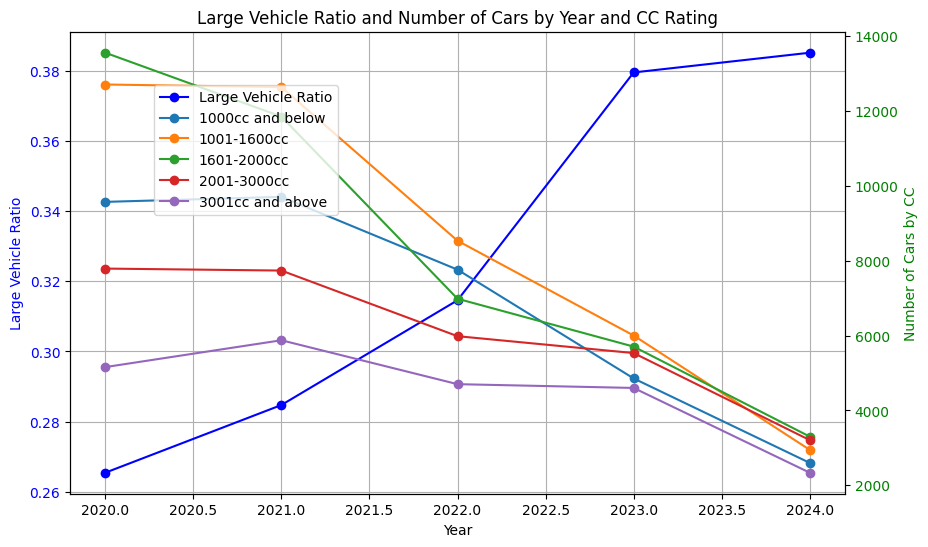

In [80]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the vehicle ratio on the left y-axis
ax1.plot(hk_yearly_vehicles_and_large_vehicle["year"], hk_yearly_vehicles_and_large_vehicle["large_vehicle_ratio"], marker='o', linestyle='-', color='b', label='Large Vehicle Ratio')
ax1.set_xlabel('Year')
ax1.set_ylabel('Large Vehicle Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin y-axis to plot number of cars by CC rating
ax2 = ax1.twinx()

# Filter the columns to exclude non-numeric and unwanted columns like 'year' and 'above_2000cc'
for cc_rating in ['1000cc and below', '1001-1600cc', '1601-2000cc', '2001-3000cc', '3001cc and above']:
    # Group the data by year and sum the number of vehicles for each cc_rating category
    cc_data = hk_vehicle[hk_vehicle['cc_rating'] == cc_rating].groupby('year').agg({'number': 'sum'}).reset_index()
    
    # Plot the data for each cc_rating
    ax2.plot(cc_data['year'], cc_data['number'], marker='o', label=cc_rating)

ax2.set_ylabel('Number of Cars by CC', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Adding a legend for the plots
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Title and grid
plt.title('Large Vehicle Ratio and Number of Cars by Year and CC Rating')
ax1.grid(True)


plt.show()

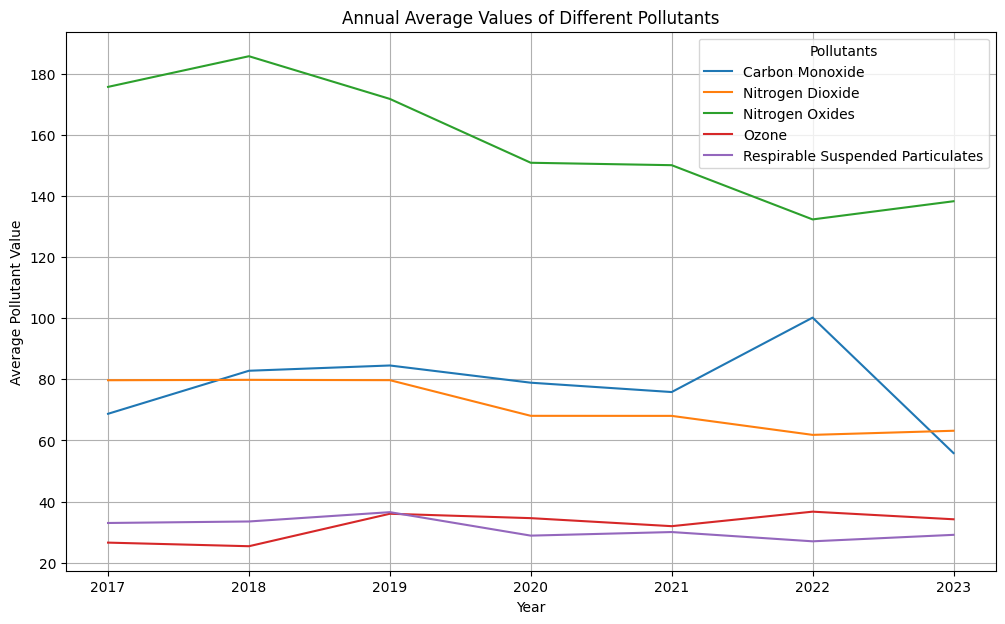

In [81]:
# Extract the pollutant to be analyzed
hk_pollutants = hk_central_annual_avg_pollutant['pollutant'].unique()

plt.figure(figsize=(12, 7))

for pollutant in hk_pollutants:
    # Filter out the current pollutant data
    hk_filtered_pollutant = hk_central_annual_avg_pollutant[hk_central_annual_avg_pollutant['pollutant'] == pollutant]    
    plt.plot( hk_filtered_pollutant['year'],  hk_filtered_pollutant['value'], label=pollutant)

plt.title('Annual Average Values of Different Pollutants')
plt.xlabel('Year')
plt.ylabel('Average Pollutant Value')
plt.legend(title='Pollutants')
plt.grid(True)
plt.show()

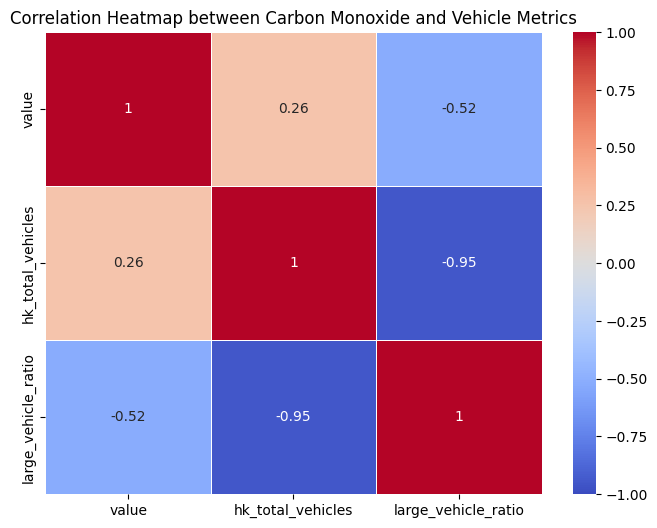

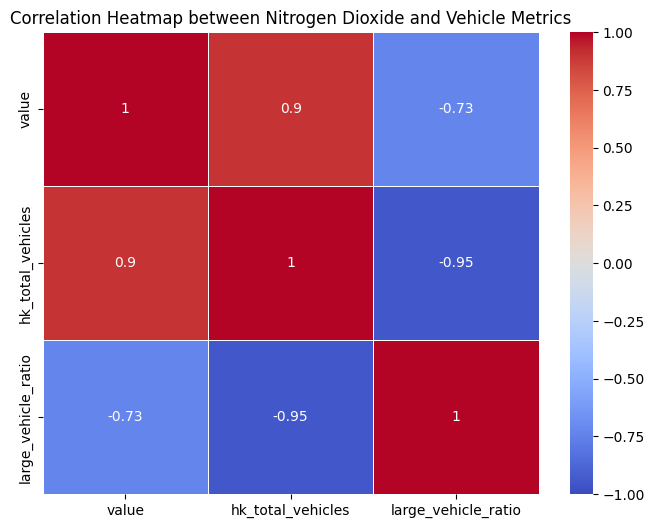

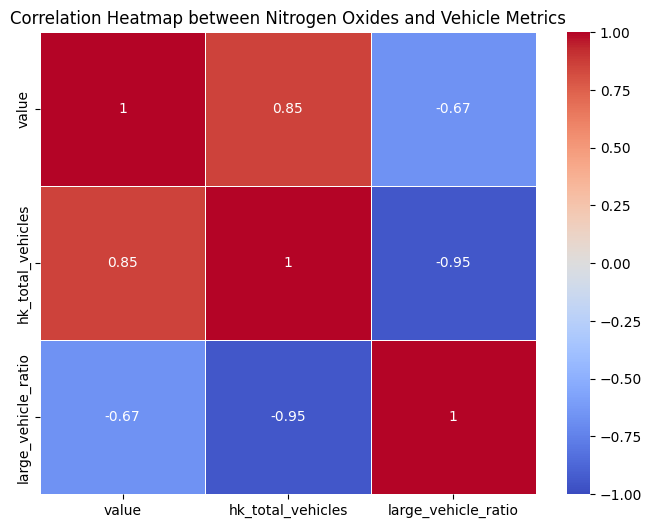

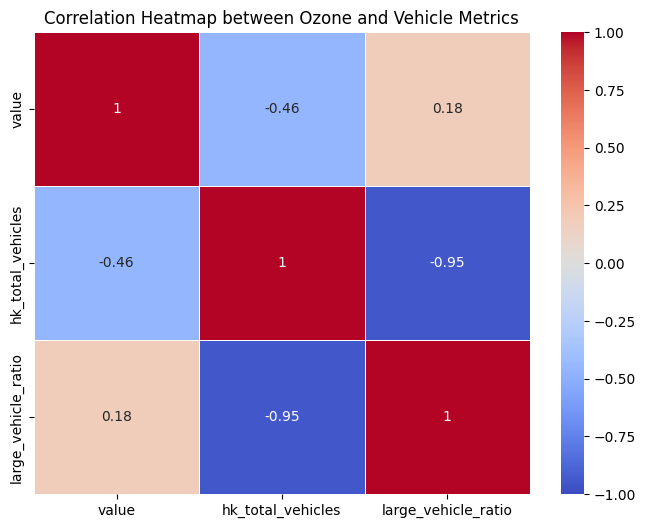

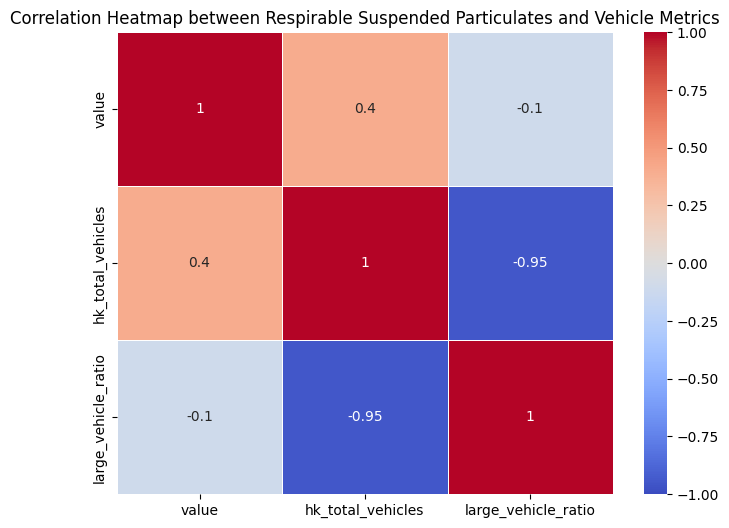

In [82]:
for pollutant in hk_pollutants:
    pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]

    correlation_matrix = pollutant_data[['value', 'hk_total_vehicles', 'large_vehicle_ratio']].corr()
    
    # Draw heat map to analysis the correlation among pollutant value, total vehicles and large vehicle ratio.
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
    plt.title(f"Correlation Heatmap between {pollutant} and Vehicle Metrics")
    plt.show()

### Data Modelling and Analysis

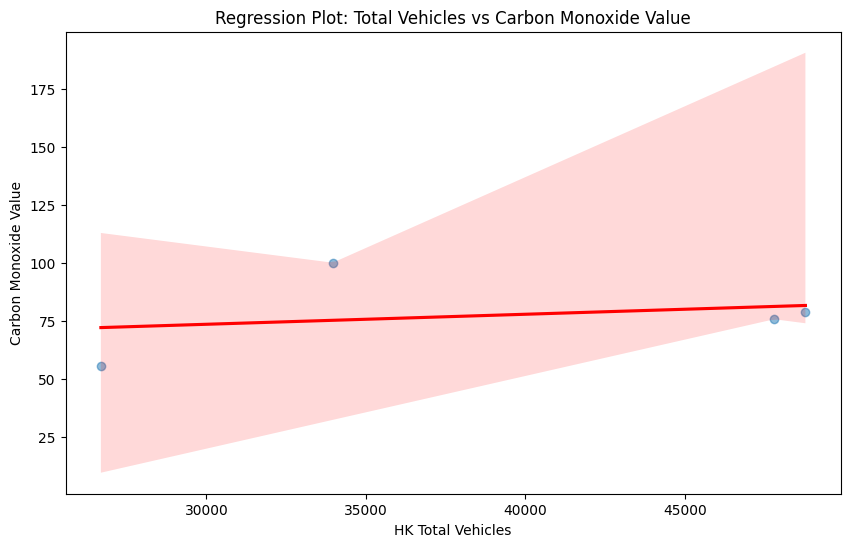

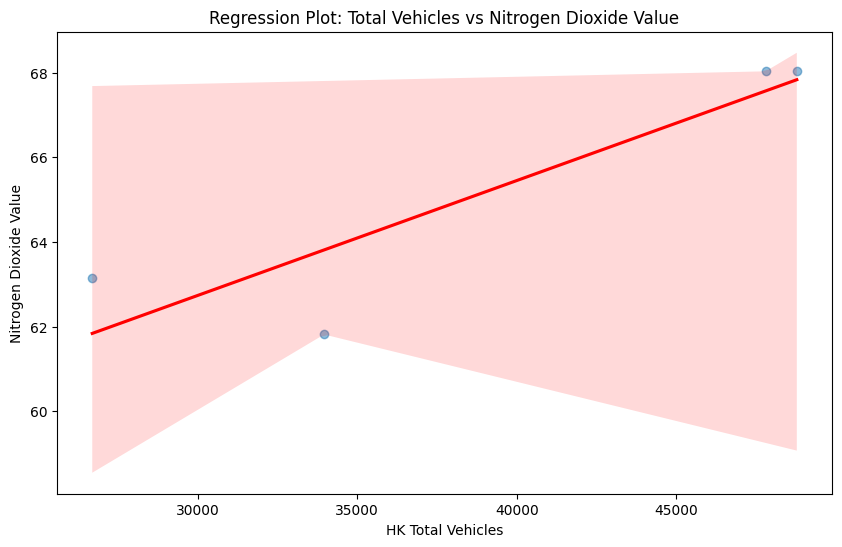

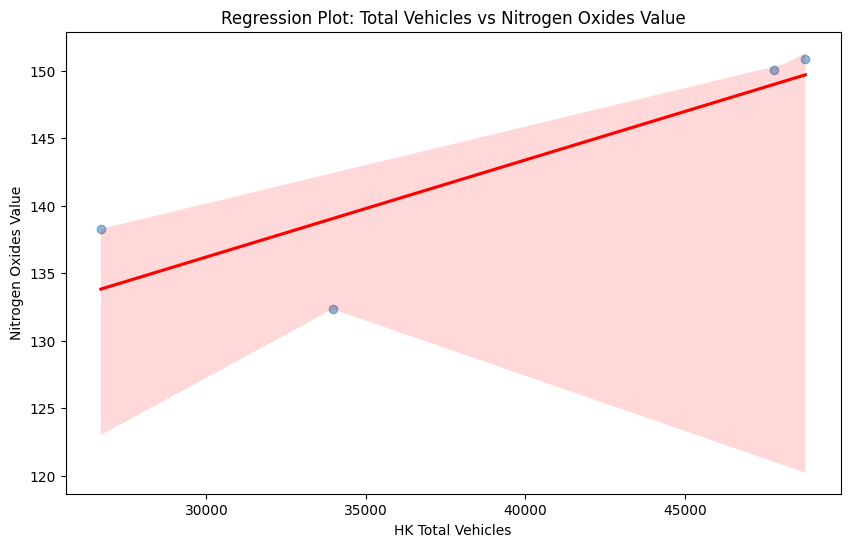

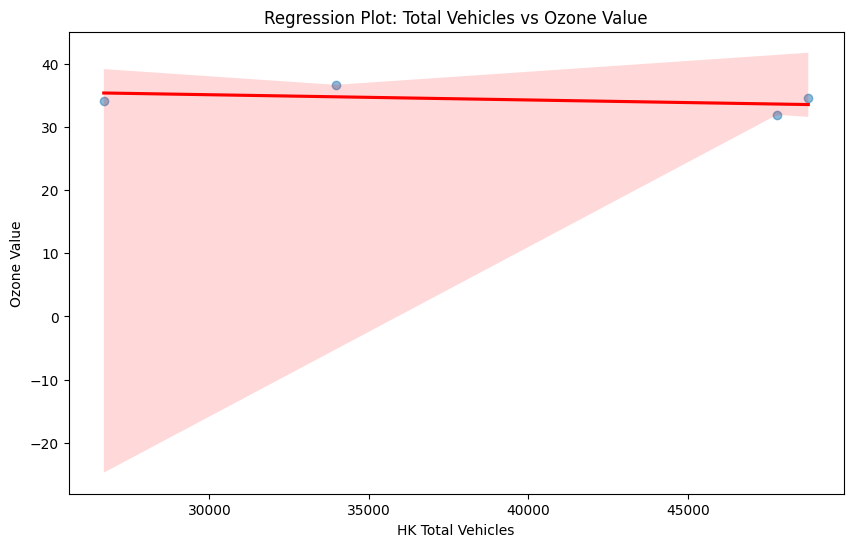

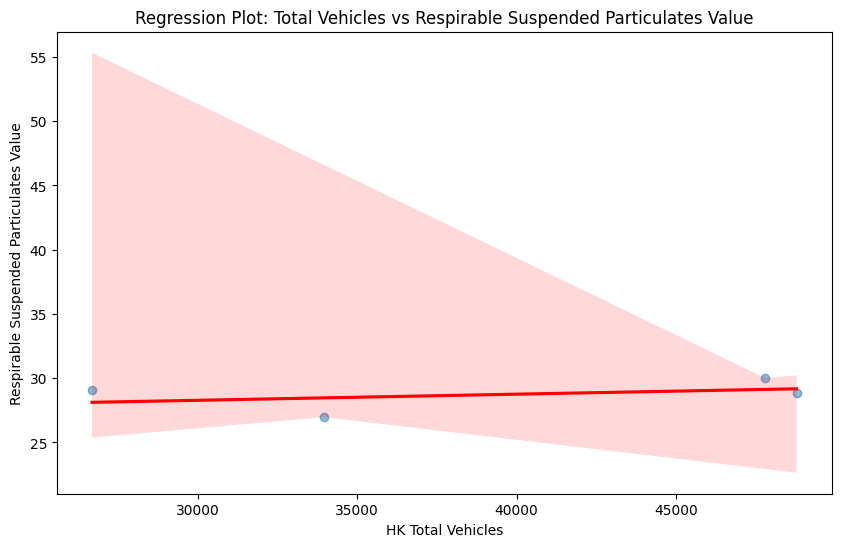

In [83]:
# Plot regression fit for each pollutant: hk_total_vehicles vs value
for pollutant in hk_pollutants:
    plt.figure(figsize=(10, 6))
    
    # Filter the data for the current pollutant
    hk_pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]
    
    # Plot regression fit for hk_total_vehicles vs value
    sns.regplot(x='hk_total_vehicles', y='value', data=hk_pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Total Vehicles vs {pollutant} Value')
    plt.xlabel('HK Total Vehicles')
    plt.ylabel(f'{pollutant} Value')
    plt.show()
# Calculate the correlation coefficient for each pollutant

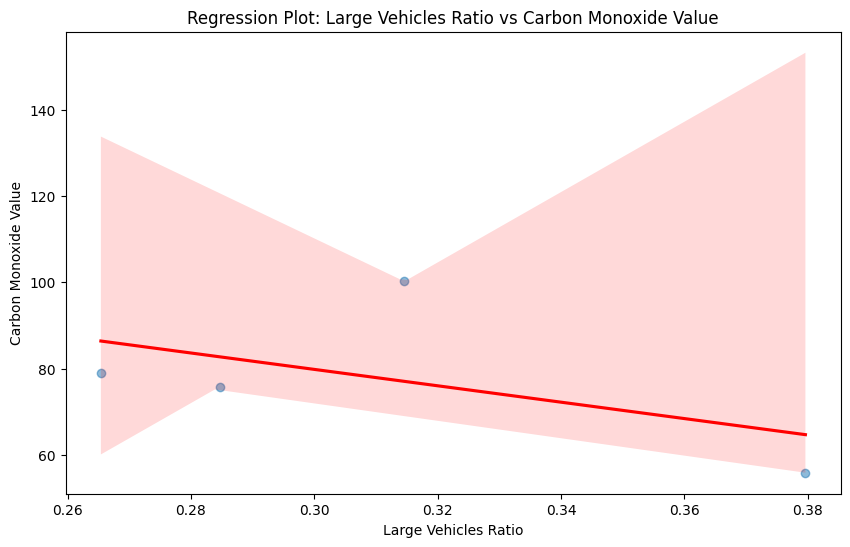

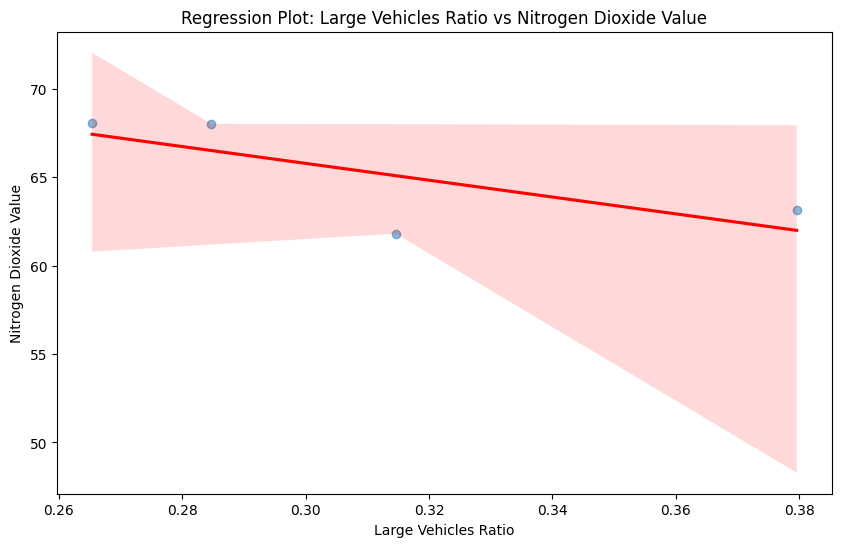

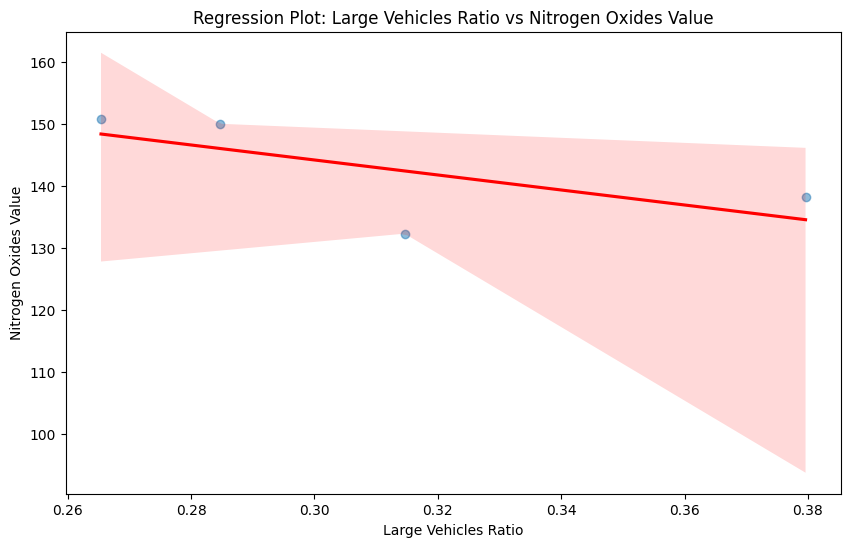

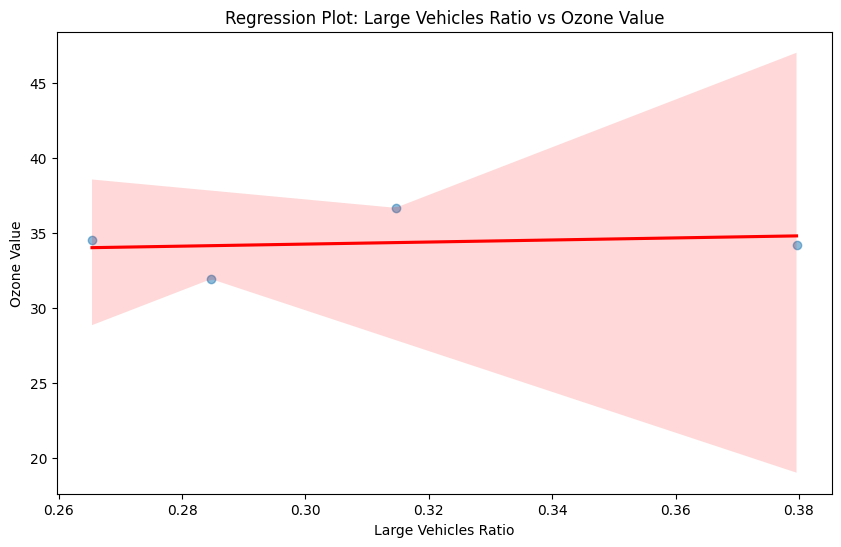

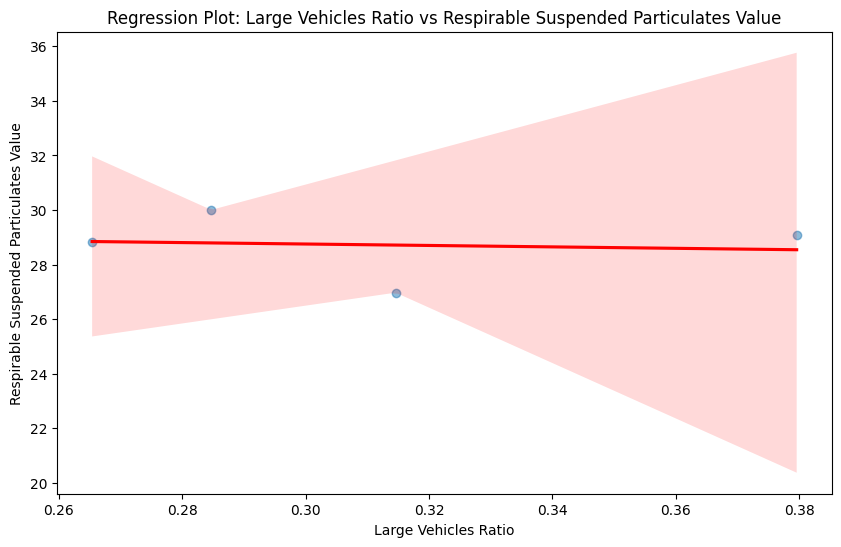

In [84]:
# Plot regression fit for each pollutant: Large Vehicles Ratio vs value
for pollutant in hk_pollutants:
    plt.figure(figsize=(10, 6))
    
    # Filter the data for the current pollutant
    hk_pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]
    
    # Plot regression fit for Large Vehicles Ratio vs value
    sns.regplot(x='large_vehicle_ratio', y='value', data=hk_pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Large Vehicles Ratio vs {pollutant} Value')
    plt.xlabel('Large Vehicles Ratio')
    plt.ylabel(f'{pollutant} Value')
    plt.show()

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/445536878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


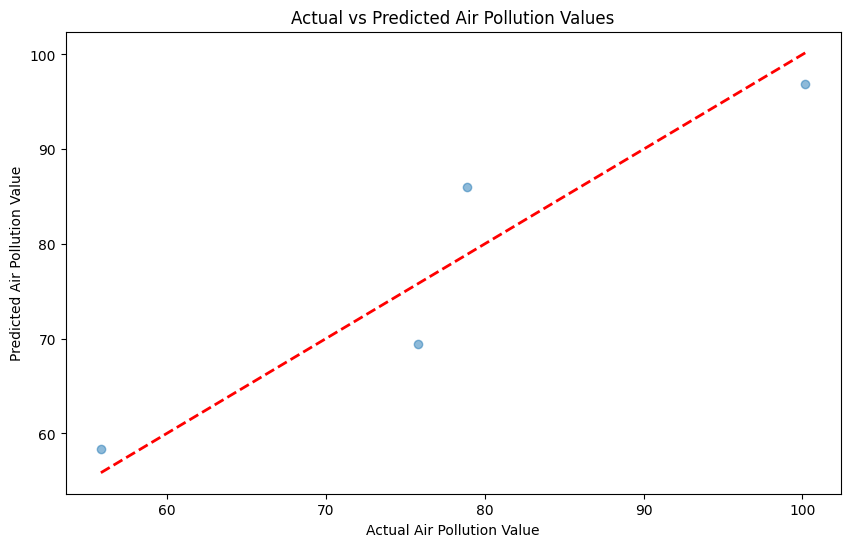

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/445536878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


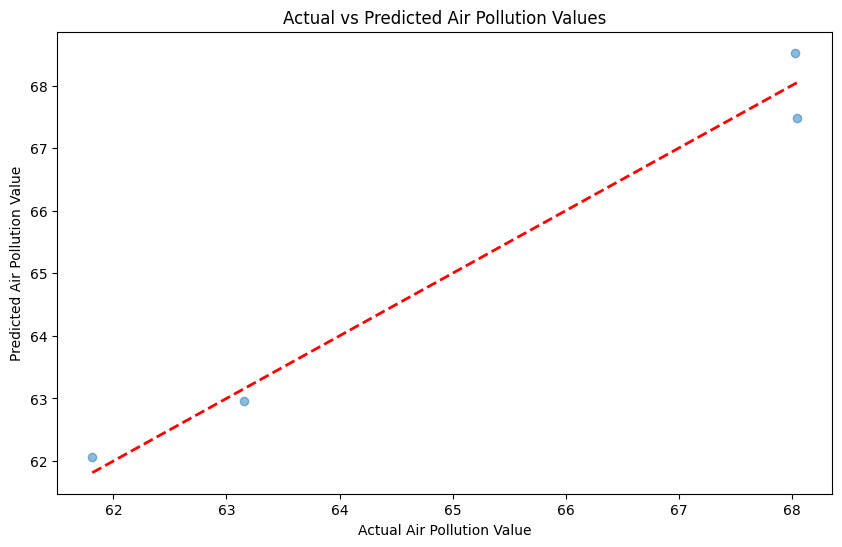

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/445536878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


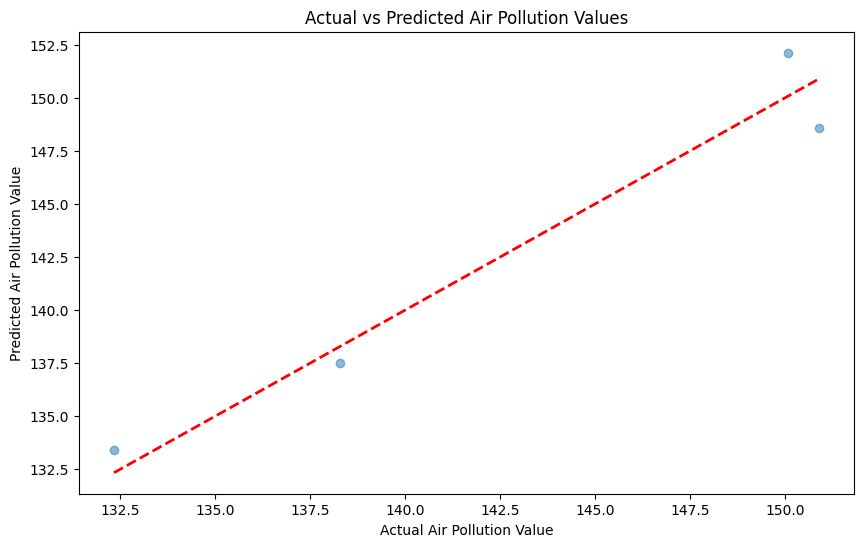

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/445536878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


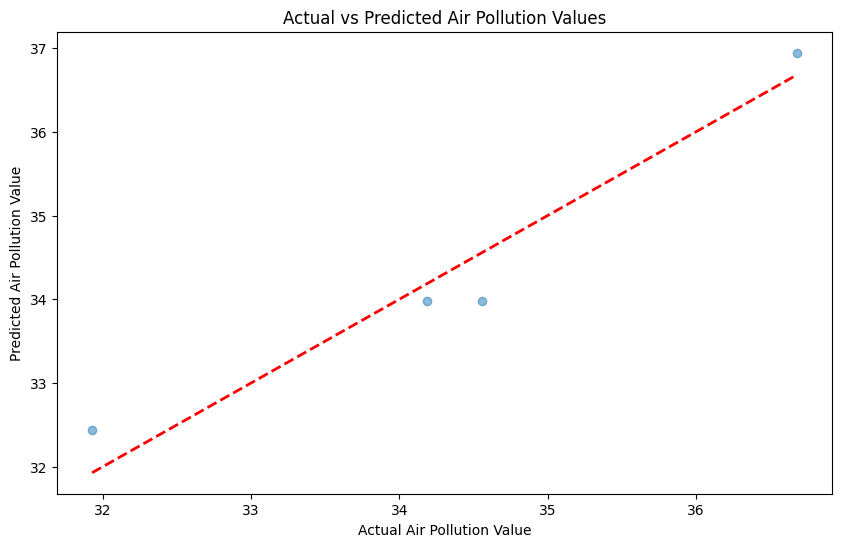

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_11458/445536878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


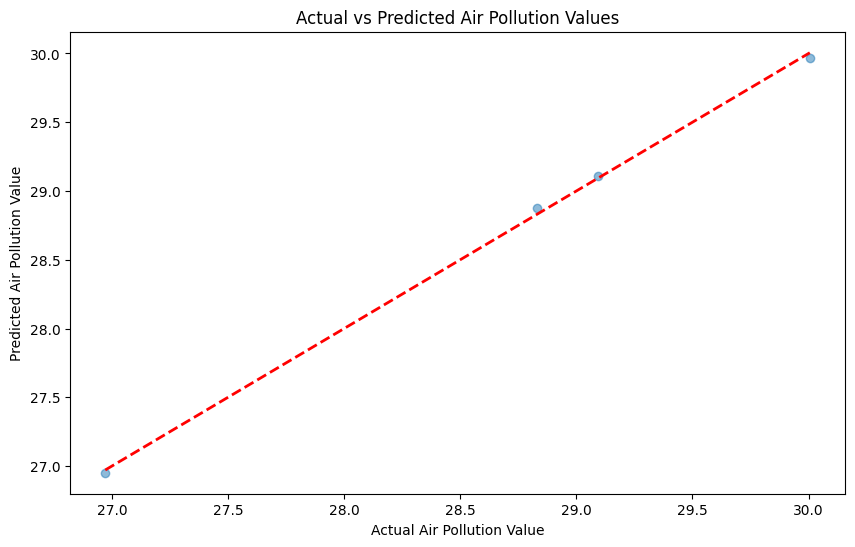

In [85]:
for pollutant in hk_pollutants:
    hk_pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]
    #  Prepare data
    X = hk_pollutant_data[['hk_total_vehicles', 'large_vehicle_ratio']]
    X = sm.add_constant(X)  # Add a constant term
    y = hk_pollutant_data['value']
    
    # Build the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Generate predicted values
    hk_pollutant_data['predicted_value'] = model.predict(X)
    
    # Plot comparison between actual values and predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(hk_pollutant_data['value'], hk_pollutant_data['predicted_value'], alpha=0.5)
    plt.plot([hk_pollutant_data['value'].min(), hk_pollutant_data['value'].max()], [hk_pollutant_data['value'].min(), hk_pollutant_data['value'].max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Air Pollution Values')
    plt.xlabel('Actual Air Pollution Value')
    plt.ylabel('Predicted Air Pollution Value')
    plt.show()

### Differences and similarities between Singapore and Hong Kong

#### 1. Heat Map

**CO(Carbon Monoxide):**

Total number of vehicles:

In Singapore, the correlation between total number of vehicles and CO is -0.097, indicating that it does not influence CO, while in Hong Kong, the correlation is 0.26, showing that it also has little influence on CO.

Large vehicles ratio:

In Singapore, the correlation between Large vehicles ratio and CO is 0.22, indicating that it does not influence the CO, while in Hong Kong, the correlation is -0.52, showing that it has a weak negative correlation with CO.

**NO2(Nitrogen Dioxide):**

Total number of vehicles:

In Singapore, the correlation between total number of vehicles and NO2 is -0.26, indicating that it does not influence NO2, while in Hong Kong, the correlation is 0.9, showing that it has a strong positive correlation with NO2.

Large vehicles ratio:

In Singapore, the correlation between Large vehicles ratio and NO2 is 0.54, indicating that it has a weak positive correlation with NO2, while in Hong Kong, the correlation is -0.73, showing that it has a negative correlation with NO2.

**O3(Ozone):**

Total number of vehicles:

In Singapore, the correlation between total number of vehicles and O3 is -0.58, indicating that it has a weak negative correlation with O3, while in Hong Kong, the correlation is -0.46, showing that it also has a weak  negative correlation with O3.

Large vehicles ratio:

In Singapore, the correlation between Large vehicles ratio and O3 is 0.87, indicating that it has a strong positive correlation with O3, while in Hong Kong, the correlation is -0.73, showing that it has a negative correlation with O3.

**Respirable Suspended Particulates (PM10 & PM25):**

Total number of vehicles:

In Singapore, the correlation between total number of vehicles and PM10 PM25 is -0.29 and -0.59, indicating that it has a negative correlation with PM10 & PM25, while in Hong Kong, the correlation is 0.4, showing that it has some positive correlation with Respirable Suspended Particulates.

Large vehicles ratio:

In Singapore, the correlation between Large vehicles ratio and PM10 PM25 is 0.15 and 0.53, indicating that it has a strong positive correlation with O3, while in Hong Kong, the correlation is -0.1, showing that it has little influence on Respirable Suspended Particulates.


#### 2. Regression analysis

For Regression analysis, the results indicate that there are significant differences between Singapore and Hong Kong (except on the correlation between Ozone and Total vehicles both shows a slightly negative result and between Respirable Suspended Particulates and Total vehicles both shows a slightly negative result). This might be due to the other influence aspects which are not taken into cosideration in this model are not identical between Singapore and Hong Kong and they are causing noises in the result of analysis.



## Part6. Conclusions and Recommendations 

**Conclusion**

1. Vehicle Type and Pollution: 

The correlation analysis revealed that larger vehicles contribute more significantly to certain types of air pollution, particularly nitrogen dioxide (NO₂), ozone (O₃), and sulfur dioxide (SO₂). These pollutants are typically associated with high combustion temperatures and greater fuel consumption, characteristics of larger engine vehicles. This finding supports the hypothesis that larger vehicles proportionately impact air quality, especially in terms of gaseous pollutants.

2. Quality Improvements Over Time: 

The downward trends in pollutants like PM10, PM2.5, and SO₂ suggest that air quality has improved in recent years, possibly due to stricter environmental regulations, advancements in vehicle technology (e.g., cleaner engines), or reduced industrial and vehicular activity. Despite this, the analysis also highlighted that certain pollutants like NO₂ and O₃ remain a concern, particularly in relation to larger vehicles.

3. Pandemic Effects: 

The peaks observed around 2020 in some pollutants, such as NO₂ and O₃, could be attributed to changes in human activity patterns during the COVID-19 pandemic. While lockdowns and movement restrictions may have temporarily reduced vehicle emissions, other factors such as industrial shifts, weather patterns, and changes in fuel consumption might have contributed to fluctuations in pollution levels.

4. Comparative Analysis with Hong Kong:

The results derived from analyzing the relationship between the total number of vehicles, the proportion of large vehicles, and air pollution in Singapore and Hong Kong are not similar, and there are even significant differences. This may be due to other factors that were not considered in the model. Given the substantial differences in the real-world situations of Singapore and Hong Kong, such results were within expectations.

**Recommendations**

Large Vehicles and Policy Implications:

The strong correlations between large vehicles and specific pollutants like O₃, SO₂, and NO₂ emphasize the need for targeted policy interventions. Measures that incentivize the use of smaller, more efficient vehicles, or that promote electric and hybrid vehicle adoption, could significantly reduce these key pollutants. Additionally, stricter emissions standards for larger vehicles could play a crucial role in improving air quality further. What's more, reducing reliance on personal vehicles by improving the affordability, accessibility, and efficiency of public transport systems can also lower the overall vehicle population and emissions, contributing to cleaner air. By encouraging carpooling and vehicle-sharing programs, Singapore can as well reduce the number of vehicles on the road, particularly during peak hours, directly lowering pollution levels.

## Part7. References 

1. Data source of Singapore air pollution:
https://api-open.data.gov.sg/v2/real-time/api/psi
2. Data source of Annual Car Population by CC Rating in Singapore:
https://datamall.lta.gov.sg/content/datamall/en/static-data.html
3. Data source of Annual Car Population in HongKong:
https://data.gov.hk/sc-data/dataset/hk-td-wcms_11-first-reg-vehicle
4. Data source of HongKong air quality:
https://cd.epic.epd.gov.hk/EPICDI/air/station/?lang=en